# ARIMA models

Classical regression or deterministic models are usually insufficient for explaining all interesting dynamics of a timeseries. In contrast, Box and Jenkins established a general strategy for time series forecasting that aim to describe the autocorrelations in the data. The introduction of correlation as a phenomenon that can arise from a lagged linear relationship has led to the introduction of autoregressive (AR) and autoregressive moving average (ARMA) models. ARMA models can be extended to deal with non-stationary time series, leading to autoregressive integrated moving average (ARIMA) model. In addition, ARIMA models can also incorporate seasonal terms (SARIMA). 

The Box-Jenkins procedure begins with differencing the series until it becomes stationary. Stationarity can be confirmed by inspection of the correlograms for a variety of differenced time series. A differenced series will be stationary when its correlogram comes to zero fairly quickly and seasonal effect has been removed (although it may remain some spikes at $s$, $2s$, ...). Then, if the series is non-seasonal, an ARMA model can be fitted to the differenced series. If the series is seasonal, then a SARIMA model can be fitted. Then, the order of the model parameters $p, P, q, Q$ is identified and the parameters of the chosen model are fitted. Finally, the fitted model has to be inspected to ensure that its corresponding residuals are random. The whole procedure is described in detail below. 

As this procedure allows the introduction of seasonal patterns, it will be applied on the raw series. This could be justified if decision making is based on the data collected, therefore, the effect should be included. On the other hand, if it is considered that the weekly seasonal effect -consequently, the lack of data- is explained by social factors (such as the fact that the weekend is not labour), then the smoothed series that does not include this effect should be studied.

# Setup

In [1]:
# data handling
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# import functions from utils
from utils import *

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# set seed to replicate results
seed=123

# SARIMA Model using raw data

First, a SARIMA model is studied on the raw data series including the effect of weekends. This is intended to show how to include seasonality in a model while respecting the original structure of the COVID-19 series. It is worth mentioning that the observed seasonal pattern corresponding to weekends probably does not characterize the phenomenon itself.

## Raw data

Read saved static data (csv file) of COVID-19 cases in Spain. More info in https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos. These data are the original series, the unprocessed data of infected persons reported by the autonomous communities.

c:\Users\Bisite\Desktop\COVID-Dynamics-Model-Comparison\data\processed-data\spanish-covid-19-data-renave-07Jul2022.csv


<AxesSubplot:title={'center':'COVID-19 Infected (raw data)'}, xlabel='Date'>

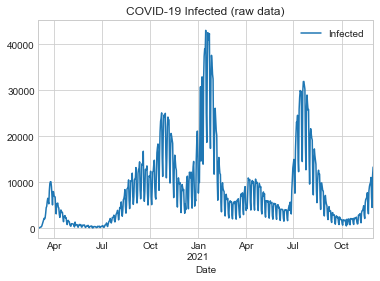

In [131]:
# read data without smoothing
df = load_last_final_data(from_folder='processed')
# keep only the infected variable
df = df[['Infected']]
# represent the series
df.plot(title='COVID-19 Infected (raw data)')


**Interpretation of the line plot**

From the above graph, it can be concluded that:
1. The data show positive and strong autocorrelation.
2. Apparently, there is no significant trend. 
3. Seasonal patterns are found each 7 days (weekly).

For the analysis to make sense, the data are divided into two subsets: train and test data. The necessary properties and settings for the model will be extracted from the train set and the model will be fitted with them. Test data will be used to make forecasts and evaluate the adjusted model. Thirty percent of the data is reserved for the test set, as in the rest of the models, so that the evaluation is comparable between them.

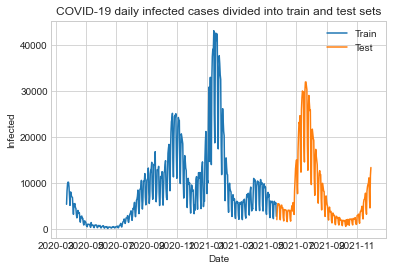

In [132]:
# divide data into train and test sets
train, test = train_test_split(df, test_size=0.3)
train = train[20:]
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('COVID-19 daily infected cases divided into train and test sets')
plt.ylabel('Infected')
plt.xlabel('Date')
plt.legend()
plt.show()

## (S)ARIMA
The first stage is model identification or obtaning initial guesses for the ARIMA parameters $p, d, q$. Identification is a necessarily inexact procedure, where graphical methods are of particular interest. Preliminary identification comes together with estimation to provide a first class of models to be fitted and diagnosed.

The objective is to identify a suitable subclass of models from the general ARIMA models family, formally expressed as:
$
\begin{equation}
\phi(B) \nabla^{d} Y_t = \theta_0 + \theta(B)a_t.
\end{equation}
$
The time series could then be described by this model (described in greater detail in the TFM report).

For this purpose, the following approach is used:
1. Produce stationarity by differencing the series $Y_t$ as many times as necessary. This would reduce the underlying process to the mixed autorregressive-moving average process:
$
\begin{equation}
\phi(B) w_t = \theta_0 + \theta(B)a_t.
\end{equation}
$
where $w_t=(1-B)^{d}Y_t = \nabla^{d}Y_t$.
2. Identify the ARMA process.

Autocorrelation and partial autocorrelation functions (and plots) will shed light on which initial parameters to take.

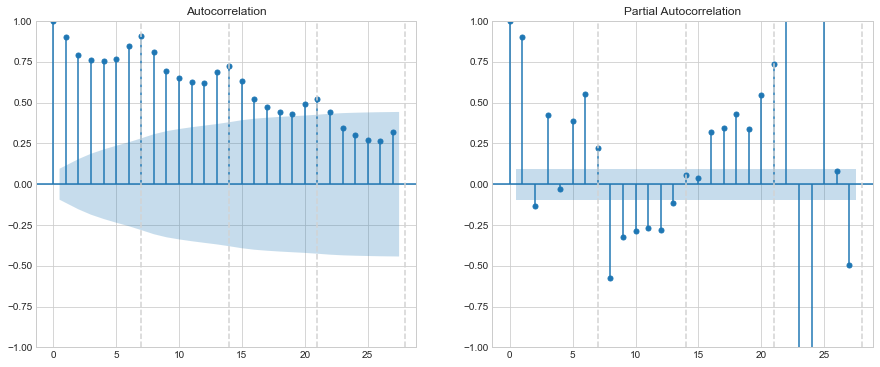

In [133]:
# show autocorrelation and partial autocorrelation plots
plot_acf_pacf(train)

**Interpretation of the autocorrelation plot**

The autocorrelation plot above shows that:
1. The sample autocorrelations are very strong and positive.
2. The sample autocorrelations decay slowly with lags.
3. Peaks are seen in the multiplies of 7, indicating seasonality.

<!-- The standard error at a lag $k$ is found under the assumption that
right model is an MA(k-1). This allows the possible interpretation: if all autocorrelations past a certain lag are within the limits, the model might be an MA of order defined by the last significant autocorrelation. -->

Failure of the estimated autocorrelation function to die out rapidly suggests that the underlying stochastic process might be treated as nonstationary in $Y_t$ but possibly as stationary in $\nabla Y_t$.

From the above, it follows that a certain degree of differentiation $d$ is needed to achieve stationarity. The nonstationary series will have been transformed into a stationary one when the autocorrelation function of $w_t=\nabla^{d}Y_t$ for some $d$ (usually $d=1$ or $d=2$) dies out quickly.

## Stationarity

In order to adjust a statistical model, we must ensure first that the timeseries is stationary. Stationarity means that the statistical properties such as mean, variance and covariance of a timeseries do not change over time. Equivalently: the properties of the series do not depend on the instant of time (time-invariant).

It the timeseries is not stationary, its properties can vary with time. Thus, the properties used at time $t$ to make a prediction at $t+k$ may be different from those observed in that prediction and therefore inaccurate.

### Tests for checking stationarity

To check the stationarity of the timeseries, two statistical tests are carried out in parallel:
1. Augmented Dickey Fuller (ADF) test: this test is used determine whether a unit root exists in a series, and thus helps to understand whether the series is stationary. 
    - Null Hypothesis: The series has a unit root (timeseries is **not** stationary).
    - Alternate Hypothesis: The series has no unit root (timeseries is stationary).
    - Results: If p-value of the test is less than significance level (p-value<$\alpha$ = 0.05), then the null hypothesis is rejected and infers that timeseries is stationary. If p-value>$\alpha$, the timeseries is not stationary and a differentiation order must be found.

2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test: another test to check the stationarity of time series. The hypothesis for this test are opposite that of the ADF test.
    - Null Hypothesis: The process is trend stationary.
    - Alternate Hypothesis: The series has a unit root (series is not stationary).
    - Results: If p-value of the test is less than significance level (p-value<$\alpha$ = 0.05), then timeseries is not stationary. If p-value>$\alpha$, the timeseries is stationary and a differentiation order must be found.

Results must be interpreted as follows:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


### Tests for checking seasonal stationarity
To check the seasonal stationarity of the timeseries, two statistical tests are carried out in parallel:
1. Osborn-Chu-Smith-Birchenhall (OCSB) test: test for seasonal unit root roots in a time series. Determines whether it needs seasonal differencing. The hypothesis are:
    - Null Hypothesis: the series contains a seasonal unit root (timeseries is not seaonal stationary).
    - Alternate Hypothesis: the series does not contain a seasonal unit root (timeseries is seasonal stationary).

2. Canova-Hansen (CH) test: test for seasonal differences. 
    - Null Hypothesis: the seasonal pattern is stable over time
    - Alternate Hypothesis: the seasonal pattern is unstable over time

In [134]:
# test stationarity on the original series
print('Stationarity tests on the original series:')
adf_test(train,  print_only_result=False)
kpss_test(train, print_only_result=False)

Stationarity tests on the original series:

ADF Test Results
-----------------
ADF Statistic: -2.7628032241559866
p-value: 0.06378663600835485
num lags: 16
Critical Values:
	1% : -3.4464005219454155
	5% : -2.868615280538588
	10% : -2.570538905413444
Result: The timeseries is not stationary

KPSS Test Results
-----------------
KPSS Statistic: 0.9685148323690967
p-value: 0.01
num lags: 11
Critical Values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Result: The timeseries is not stationary


ADF test indicates stationarity but KPSS does not: the series is difference stationarity. The series with the first difference has to be studied.

In [135]:
# test seasonal stationarity of the transformed series
OCSB_D_recommendation = pm.arima.OCSBTest(m=7).estimate_seasonal_differencing_term(train)
CH_D_recommendation = pm.arima.CHTest(m=7).estimate_seasonal_differencing_term(train)

print('Seasonal differencing term recommendation:')
print('-------------------------------------------')
print('OCSB:', OCSB_D_recommendation)
print('CH:', CH_D_recommendation)

Seasonal differencing term recommendation:
-------------------------------------------
OCSB: 0
CH: 0


The series does not require a seasonal difference.

### Differenced series

The plot below shows the differenced series for $d=1$. 

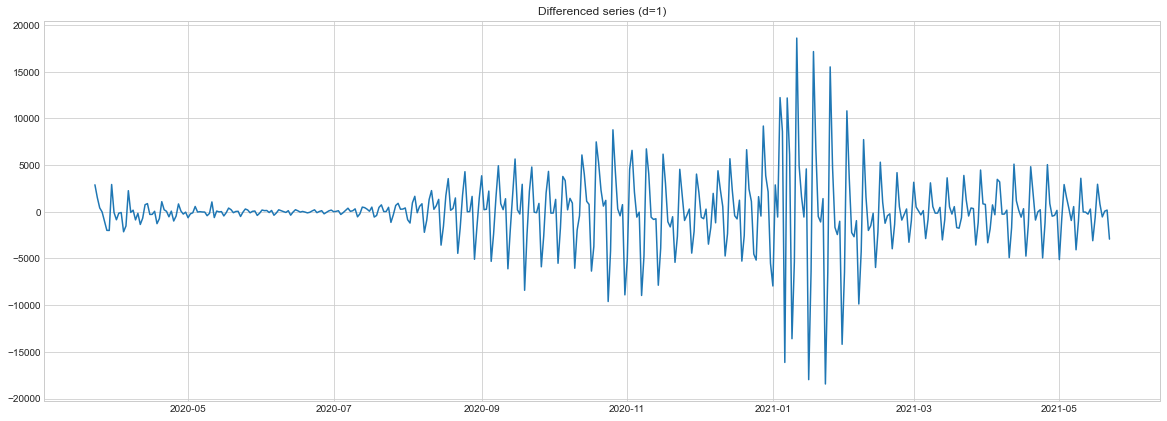

In [136]:
# take one difference (d=1)
df_d1 = train.diff().dropna()
# plot the differenced series
fig = plt.figure(figsize=(20, 7))
plt.title('Differenced series (d=1)')
plt.plot(df_d1)

**Interpretation of the differenced series**

The differenced series vary around zero (constant mean) now. However, it can be observed that the series fluctuates around this zero mean with a variable variance. Therefore, a logarithm transform of the observations has to be applied to stabilize the variance.

### Log transform

From the line graph of the initial series it can also be deduced that it is necessary to apply a transformation to the data. Since the seasonal effect appears to be multiplicative, a logarithmic transformation is recommended to make the seasonal effect additive (constant from period to period). However, it is important to take into account that this transformation will only stabilize the variance if the error term is also multiplicative. 

**Note:** This transformation has to be applied on the original series and then take the first difference on it; it would be absurd to apply the log transformation to the previous differenced series since it has zero values.

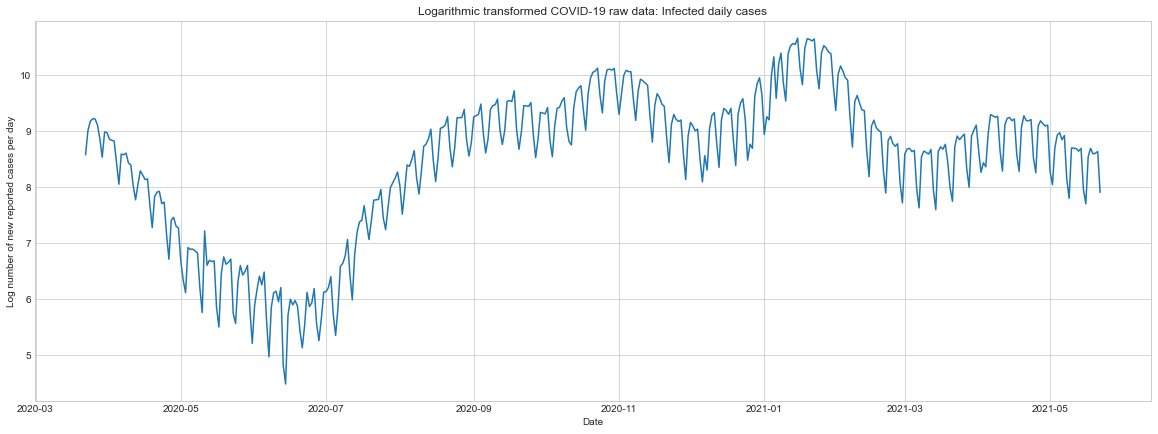

In [137]:
# apply a log transformation to the original data (having ensured that there is no zero value)
log_series = np.log(train)

# plot log-transformed data to confirm that the seasonal effect is now additive
fig = plt.figure(figsize=(20, 7))
plt.plot(log_series)
plt.xlabel('Date')
plt.ylabel('Log number of new reported cases per day')
plt.title('Logarithmic transformed COVID-19 raw data: Infected daily cases')
plt.show()

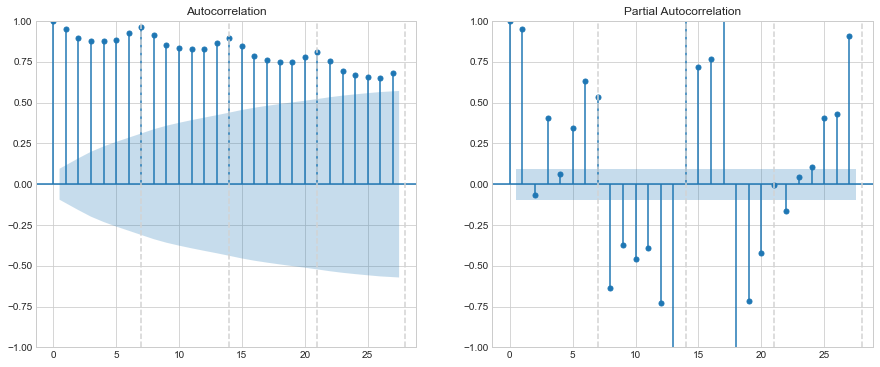

In [138]:
plot_acf_pacf(log_series)

The log transformation appears to have been reasonable: the seasonal fluctuations are preserved but now they are in an additive fashion. 

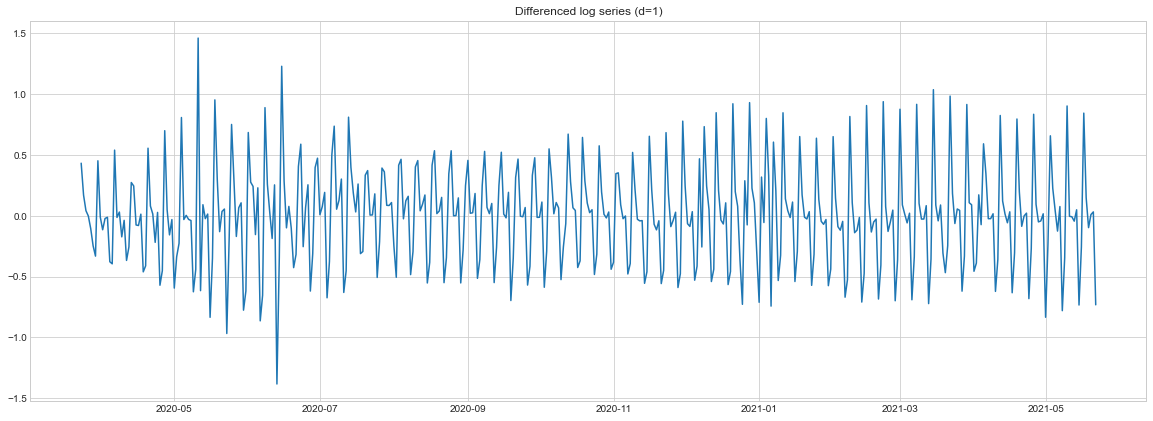

In [139]:
# difference the log series
df_d1 = log_series.diff().dropna()

# plot the resulting series
fig = plt.figure(figsize=(20, 7))
plt.title('Differenced log series (d=1)')
plt.plot(df_d1)

The graph above shows a more stationary version of the series is obtained: constant mean around zero, constant variance around the mean.

The next step now is to examine the ACF and PACF plots for the differenced series:

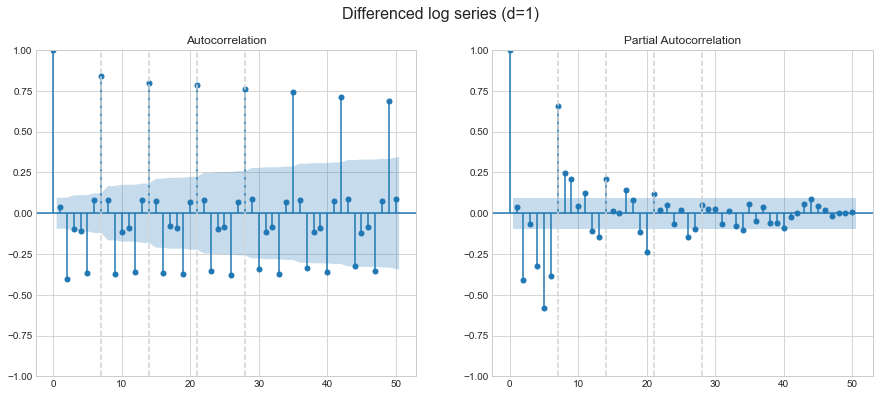

In [140]:
plot_acf_pacf(df_d1, 'Differenced log series (d=1)', lags=50)

The ACF shows constant peaks in the coefficients of 7, 14, ... lags, indicating the presence of a significant 7 period seasonal component. These seasonal components in the ACF remain constant with lag increase; in the PACF they tend to decay towards zero. The series does not exhibit stable seasonal behaviuor (oscillations), so there would be no need to take seasonal differences.

### Check stationarity of transformed series

Finally, the stationarity (regular and seasonal) of the transformed series should be checked. 

In [141]:
# test stationarity on the transformed series
print('Stationarity tests on the transformed series:')
adf_test(df_d1)
kpss_test(df_d1)

Stationarity tests on the transformed series:

ADF Test Results
-----------------
Result: The timeseries is not stationary

KPSS Test Results
-----------------
Result: The timeseries is stationary


In [142]:
# test seasonal stationarity of the transformed series
OCSB_D_recommendation = pm.arima.OCSBTest(m=7).estimate_seasonal_differencing_term(df_d1)
CH_D_recommendation = pm.arima.CHTest(m=7).estimate_seasonal_differencing_term(df_d1)

print('Seasonal differencing term recommendation:')
print('-------------------------------------------')
print('OCSB:', OCSB_D_recommendation)
print('CH:', CH_D_recommendation)

Seasonal differencing term recommendation:
-------------------------------------------
OCSB: 0
CH: 0


When testing stationarity, the tests concludes that this series is stationary and seasonal stationary for both OCSB and CH tests.

## Estimation of ARIMA models

Once the stationarity parameters (d, D) has been derived, a preliminary type of model should be provided and then the residuals must be studied to add to the previous model the structure that it was missing. 

Equivalently, the process of seeking the best order of parameters can be performed automatically. Given an information criterion (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively), different combinations of parameter orders are tested in order to minimize the value obtained with the criterion. This is the approach to be used. 

**Note:** It should be noted that, although there are functions capable of finding the optimal order of the parameters, it is not advisable to use them without previously knowing d and D. This is because the operation of differentiating converts one data series into a different one. Therefore, likelihood is calculated on two different series and, consequently, the values of the information criterion (commonly AIC or BIC) between models that have different orders of differencing cannot be compared. 
In definitive, this method is only recommended to find the order of p, q, P, Q.

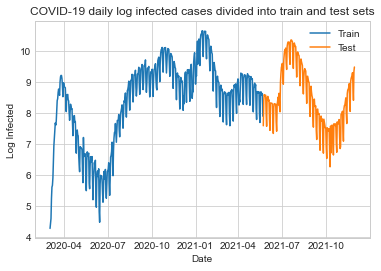

In [143]:
log_df = np.log(df)
log_train, log_test = train_test_split(log_df, test_size=0.3)
plt.plot(log_train, label='Train')
plt.plot(log_test, label='Test')
plt.title('COVID-19 daily log infected cases divided into train and test sets')
plt.ylabel('Log Infected')
plt.xlabel('Date')
plt.legend()
plt.show()

Search best order for the $p, P, q, Q$:

In [144]:
# search arima best params
model = pm.auto_arima(np.array(log_train), 
                    seasonal=True, 
                    m=7, 
                    d=1, 
                    D=0, 
                    error_action='ignore', 
                    parallelized=True)

And print the results:

In [145]:
model_parameters = model.get_params()
order = model_parameters['order']
seasonal_order = model_parameters['seasonal_order']

print('Best estimated order: \n\t (p, d, q) =', order)
print('Best estimated seasonal order: \n\t (P, D, Q, m) =', seasonal_order)

Best estimated order: 
	 (p, d, q) = (1, 1, 3)
Best estimated seasonal order: 
	 (P, D, Q, m) = (1, 0, 2, 7)


## Model Diagnostic Checking

Residuals are defined as the difference between the observations and the fitted values. They are indispensable to check whether a model captures all information in the data correctly. Visual inspection of a plot of the residuals themselves is an essential first step in the checking process. A forecasting method would be considered adequate if the resulting residuals verify the next properties:

1. Uncorrelation: If the residuals are autocorrelated, then the residuals still contain information left that should be added to the model.
2. Zero mean: Residuals with a mean other than zero indicate bias in forecasts.

If either of these properties is not satisfied, then the model can be modified to provide better forecasts. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method. 


In addition to the properties above, it is convenient (although not necessary) for the residuals to also have the following properties:

3. Homocedasticity (i.e, constant variance)
4. Normal distribution

However, a forecasting method that does not satisfy these properties cannot necessarily be improved. These additional properties are important in the calculation of prediction intervals.


#### (S)ARIMA Results

The following tests and concepts will be used to ensure and verify the above.

- Ljung-Box Test: tests whether the errores are white noise by checking if the autocorrelations of the residuals are zero. It can be thought as a test of lack of fit: if the sample autocorrelations of residuals are close to zero, there is no missing structure to be added to the model and therefore it does not show significant lack of fit.
    - $H_0$: The residuals are independently distributed (autocorrelations in the population from which the sample is taken are zero; any observed aucorrelation in the residuals result from randomness of the sampling process). (the model is correctly fitted)
    - $H_1$: The residuals are not independently distributed (exhibit serial correlation).
    - A significant $p-$ value (<0.05) rejects $H_0$ that the autocorrelations are zero; $p-$ value>0.05 is sought in order not to reject $H_0$.


- Heteroskedasticity Test: test fot heteroskedasticity of standarized residuals; tests whether residuals are homocedastic (they have the same variance).
    - $H_0$: No heteroskedasticity.
    - $H_1$: Heteroskedasticity.
    - A significant $p-$ value rejects $H_0$ that the residuals are not heteroskedastic; $p-$ value>0.05 is preferred in order not to reject $H_0$.
    

- Jarque-Bera Test: test for normality of standarized residuals. As part of this test, skew and kurtosis are also computed. 
    - $H_0$: Normality.
    - $H_1$: No normality; residuals follow another distribution.
    - A significant $p-$ value rejects $H_0$ that the residuals are normally distributed; $p-$ value>0.05 is preferred in order not to reject $H_0$.


The stage of selecting the best model involves some probabilistic criteria, capable of measure model performance and model complexity on the training set. The actual value of the measure for a model is irrelevant on its own; the purpose of these criteria is the comparison of models. The following are displayed in the next analysis:
- Log likelihood: this function identifies the distribution that fits best the training data. The higher the value of the log-likelihood, the better a model fits a dataset. The log-likelihood value obtained can range from negative infinity to positive infinity. Adding predictor variables to a model will increase the log-likelihood value even if the additional predictor variables aren’t statistically significant, leading to overfitting.
- AIC (Akaike Information Criterion): Estimates the amount of information lost by a given model: the less information the model loses, the higher the quality of the model. AIC addresses the trade-off between model goodness of fit and model simplicity. In other words, AIC addresses the risk of overfitting and the risk of underfitting.
- BIC: Lower BIC models are usually preferred. It is partly based on probability functions and is closely related to the AIC. When fitting the model, the likelihood can be increased by adding parameters, but this can lead to overfitting. Both BIC and AIC attempt to address this problem by introducing a penalty term for the number of parameters in the model; BIC has a larger penalty term than AIC.
- HQIC: As in AIC, HQC introduces a penalty term for the number of parameters in the model, but the penalty is greater than one in AIC. The model with the lower HQC value is preferred; a lower HQC implies a smaller number of explanatory variables, better fit, or both. In practice, it seems to have seen little use.

In [146]:
print(model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  447
Model:             SARIMAX(1, 1, 3)x(1, 0, [1, 2], 7)   Log Likelihood                 125.297
Date:                                Thu, 11 Aug 2022   AIC                           -234.594
Time:                                        17:35:36   BIC                           -201.791
Sample:                                             0   HQIC                          -221.661
                                                - 447                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9612      0.020     48.630      0.000       0.922       1.000
ma.

#### Interpretation of model results
 
Residuals diagnostic:

- Ljung-Box (L1) (Q) is the Ljung-Box test at lag 1. The value of the statistic is 0.01 and the $p$ -value is 0.93>0.05. This implies that the $H_0$ is not rejected and therefore the residuals are white noise.
- Heteroskedasticity (H). The test statistic is 0.88 and the $p$ -value is 0.46>0.05. This implies that the $H_0$ is not rejected and therefore the residuals are not heteroskedastic.
- Jarque-Bera (JB) statistic is 263.17 and the $p$ -value is 0<0.05. This implies that the $H_0$ is rejected and therefore the residuals are not normally distributed. In addition, the residuals have a slight negative skew and a pretty large kurtosis.

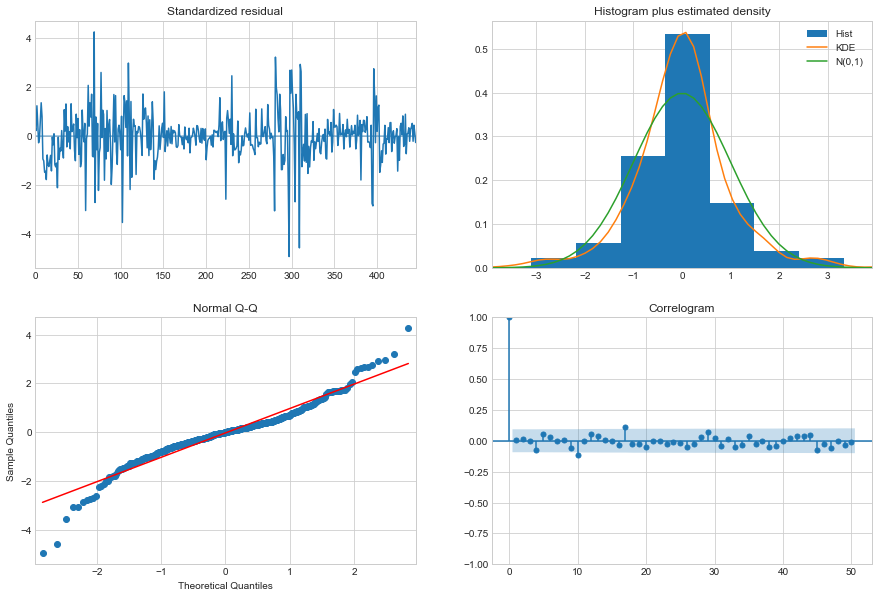

In [147]:
# graphic diagnostic
model.plot_diagnostics(figsize=(15,10), lags=50)
plt.show()

**Interpretation of the diagnostics graphs**

- The standarized residuals seem to have **zero mean** and have a shape similar to the white noise. 
- The histogram and density plot show how the residuals **differ from a normal distribution**. It can be seen the slight **negative skew and a positive excess of kurtosis**.
- The Q-Q plot can help to asses if the residuals came from a theoretical normal distribution. If both sample-theoretical sets of quantiles came from the same distribution, the points should form a diagonal straight line. In this case, the Q-Q plot shows a distribution with **heavy tails** (as confirmed by the kurtosis above) vs. the normal distribution: most points are clustered on a line in the center of the plot, and some points curve (due to slight negative) and move away from the line in the extremities (due to slight negative skew and kurtosis). This means that the residuals have more extreme values or **outliers** relative to a normal distribution. <!-- https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html -->
- The correlogram help in identifying the residuals randomness. The standard errors for confidence intervals are determined under the hypothesis that the residuals are white noise. Since they are close to zero and almost none exceed the confidence intervals, the **residuals are white noise**.

#### Conclusion

The best model found is SARIMA(1, 1, 3)x(1, 0, 2, 7), this is:
- AR(1): the current value of the series $Y_t$ depends on the previous value $Y_{t-1}$ of the series adjusted by some parameters (plus a constant term and a white noise value $\varepsilon_t$). 
- d=1: the series has no constant properties, so a difference is necessary.
- MA(3): the current value of the series $Y_t$ depends on the adjusted three previous white noise term $\varepsilon_{t-1}, \varepsilon_{t-2}, \varepsilon_{t-3}$ (plus a constant term and the current white noise term $\varepsilon_{t}$).
- The seasonal part has period 7 with AR(1), MA(2) and needs no differencing ($D=0$). 

The residuals diagnostic concludes that the model captures all the non random patterns in data. This means that if the conditions that have generated this series are maintained, then the model collects all the information available and will predict correctly.

## SARIMA modeling

Having studied the properties of the SARIMA model that best describes the series, it is now shown how to use this model to forecast future values of an observed time series. The final objective here is to quantify the errors made by the model in predicting 14 future instants.

## Methodology

The procedure is as follows:
1. Choose the maximum time horizon up to which to obtain predictions (steps_ahead). By default, steps_ahead=14. In addition, the SARIMA class receives as argument the order of the parameters of the best model found: order=(p, d, q) and seasonal_order=(P, D, Q). They are set by default to 
order=(1, 1, 3) and seasonal_order=(1, 0, 2, 7), as stated above. 
2. The whole univariate series is then divided into train and test subsets. Train data are used to fit the model (estimate its parameters) and test data are used to evaluate the model. Evaluation mode is walk forward validation with expanding windows (see [expanding windows scheme](https://github.com/marialonsogar/COVID-Dynamics-Model-Comparison/blob/main/analysis/walk-forward-expanding-scheme.png)).
 
3. To generate forecasts at time $t$ up to $t+k$, the model has to be fitted with the points until $t$. 

**Notes:**

- The function plot_windows(max_subplots) displays max_subplots plots made of the last 14 points of a random train window (see scheme above) followed by the corresponding test window and the forecasts. Note that the purpose of this function is merely illustrative and the order of the series is always preserved as it is mandatory in any time series analysis.

In [78]:
class SARIMA:

    def __init__(self, data, steps_ahead=14, 
                order=(1, 1, 3), seasonal_order=(1, 0, 2, 7), metrics=metrics, cut_value=0):
        self.steps_ahead = steps_ahead
        self.order = order
        self.seasonal_order = seasonal_order
        self.metrics = metrics
        self.cut_value = cut_value

        # store data
        self.data = np.array(data)
        self.train, self.test = self.train_test_split(self.data)

        self.model = self.fit_model()

        self.all_forecasts = None
        self.all_forecasts_ci = None
        self.baseline = None
    
    def train_test_split(self, data=None, test_size=0.3):
        """
        Split data into training and test sets
        Args:
            data: data to be split
        Returns:
            train: training data
            test: test data
        """
        if data is None:
            data = self.data
        train, test = train_test_split(data, test_size=test_size)
        train = train[self.cut_value:]
        return np.array(train).ravel(), np.array(test).ravel()

    def random_windows(self):
        """
        Generate random windows
        """           
        # divide test in sliding windows
        test_windows = np.lib.stride_tricks.sliding_window_view(np.array(self.test).ravel(), self.steps_ahead)
        # take random index
        random_index = np.random.randint(0, test_windows.shape[0]-1)
        # history to train the model up to random_index
        history = np.append(self.train, self.test[:random_index]).ravel()
        model = self.fit_model(history)
        predicted_mean, predicted_ci = self.predict(model=model, return_ci=True)
    
        return np.exp(history), np.exp(test_windows[random_index]), np.exp(predicted_mean), np.exp(predicted_ci)

    def plot_windows(self, max_subplots=3):
        """
        Plot real infected data, the predictions and the baseline to compare
        Args:
            max_subplots (int): maximum number of subplots to plot
        """
        # seed to replicate results 
        np.random.seed(seed)
        
        example_windows = [self.random_windows() for _ in range(max_subplots)]

        for history, test_window, predicted_mean, predicted_ci in example_windows:
            t_window = np.arange(self.steps_ahead+self.steps_ahead)
            history_window = history[-self.steps_ahead:]

            plt.figure(figsize=(8, 5))
            #plot historical Infected
            plt.plot(t_window[:self.steps_ahead+1], np.append(history_window, test_window[0]), color='dodgerblue', label='I real',marker='o')
            #plot predicted mean Infected
            plt.plot(t_window[self.steps_ahead:], predicted_mean, color='darkorange', label='I predicted', marker='o')
            # #plot predicted confidence interval
            # plt.fill_between(t_window[self.steps_ahead:], predicted_ci[:,0], predicted_ci[:,1], color='darkorange', alpha=0.2)
            # plot I test
            plt.plot(t_window[self.steps_ahead:], test_window, color='blue', label='I test', marker='o')

            plt.ylabel('Infected')
            plt.xlabel('Time steps')
            plt.legend()
            plt.show()

    def get_best_SARIMA_model(self, print_summary=False, print_best_orders=True):
        """Automatically find the best SARIMA model for the given data"""
        model = pm.auto_arima(np.array(train), 
                    seasonal=True, 
                    m=7, # seasonality period
                    d=1, # difference necessary to achieve stationarity
                    D=0, # difference necessary to achieve seasonal stationarity
                    error_action='ignore', 
                    parallelized=True)

        # get the model parameters
        model_parameters = model.get_params()
        # get the best order and seasonal order
        best_order = model_parameters['order']
        best_seasonal_order = model_parameters['seasonal_order']
        if print_best_orders:
            print('Best estimated order: \n\t (p, d, q) =', best_order)
            print('Best estimated seasonal order: \n\t (P, D, Q, m) =', best_seasonal_order)
        if print_summary:
            print(model.summary())
        return model

    def fit_model(self, train_data=None):
        """Fit the model"""
        if train_data is None:
            train_data = self.train
        model = SARIMAX(train_data, order=self.order, seasonal_order=self.seasonal_order).fit()
        return model

    def predict(self, model=None, steps_ahead=None, return_ci=True):
        """
        Predict the future values of the time series
        Args:
            model: model to be used for prediction
            steps_ahead: number of steps ahead to predict
        Returns:
            predicted: predicted values
        """
        if model is None:
            model = self.model
        if steps_ahead is None:
            steps_ahead = self.steps_ahead

        forecast = model.get_forecast(steps=steps_ahead)
        predicted_mean = forecast.predicted_mean
        if return_ci:
            predicted_ci = forecast.conf_int()
            return predicted_mean, predicted_ci
        else:
            return predicted_mean

    def _evaluate(self, y_true, y_forecasted):
        """
        Evaluate the performance of the model
        """
        evaluation = {}

        # evaluate
        for metric_name, metric in self.metrics.items():
            try:
                evaluation[metric_name] = metric(y_true, y_forecasted)
                # baseline_step_evaluation[metric_name] = metric(test_step, baseline_step)
            except:
                evaluation[metric_name] = np.nan
                # baseline_step_evaluation[metric_name] = np.nan
        return evaluation

    def predict_windows(self, steps_ahead=None, verbose=False):

        if steps_ahead is None:
            steps_ahead = self.steps_ahead
        
        forecasts = []
        forecasts_ci = []
        baseline = []

        history = self.train
        
        # walk-forward validation
        for t in range(len(self.test)-(steps_ahead-1)):
            # train model up to the final available time point
            model = self.fit_model(history)
            # make prediction
            predicted, predicted_ci = self.predict(model, steps_ahead=steps_ahead, return_ci=True)
            # store the prediction
            forecasts.append(predicted)
            forecasts_ci.append(predicted_ci)
            baseline.append(history[-1])
            # update the history
            history = np.append(history, self.test[t])

            if verbose:
                print(f'Observed: {self.test[t]}, Predicted: {predicted[steps_ahead-1]}, CI: {predicted_ci[steps_ahead-1]}')

            self.all_forecasts = np.array(np.exp(forecasts))
            self.all_forecasts_ci =  np.array(np.exp(forecasts_ci))
            self.baseline = np.array(np.exp(baseline))
            
        return self.all_forecasts, self.all_forecasts_ci, self.baseline

    def predict_train_windows(self, steps_ahead=None, verbose=False):

        if steps_ahead is None:
            steps_ahead = self.steps_ahead
        
        forecasts = []
        forecasts_ci = []

        history = self.train[:steps_ahead]
        
        
        # walk-forward validation
        for t in range(steps_ahead,len(self.train)-(steps_ahead-1)):
            model = self.fit_model(history)
            # make prediction
            predicted, predicted_ci = self.predict(model, steps_ahead=steps_ahead, return_ci=True)
            # store the prediction
            forecasts.append(predicted)
            forecasts_ci.append(predicted_ci)
            # update the history
            history = np.append(history, self.train[t])

            if verbose:
                print(f'Observed: {self.train[t]}, Predicted: {predicted[steps_ahead-1]}, CI: {predicted_ci[steps_ahead-1]}')

            train_all_forecasts = np.array(np.exp(forecasts))
            train_all_forecasts_ci =  np.array(np.exp(forecasts_ci))
            
        return train_all_forecasts, train_all_forecasts_ci

    def evaluate_step(self, forecasts=None, baseline=None, steps_ahead=None):
        evaluation = {}

        if (forecasts is None) and (baseline is None):
            forecasts, _, baseline = self.predict_windows(steps_ahead=steps_ahead)
        if steps_ahead is None:
            steps_ahead = self.steps_ahead

        # evaluate the model in the step 
        forecasts = forecasts[:, (steps_ahead-1)].ravel()
        test_windows = np.lib.stride_tricks.sliding_window_view(np.array(self.test).ravel(), self.steps_ahead)
        test = test_windows[:, (steps_ahead-1)].ravel()

        evaluation[f'step_{steps_ahead}'] = self._evaluate(np.exp(test), forecasts)
        evaluation[f'baseline_step_{steps_ahead}'] = self._evaluate(np.exp(test), np.array(baseline).ravel())
        return evaluation

    def evaluate(self):
        """
        Evaluate the model
        """
        evaluation = {}

        if self.all_forecasts is not None:
            forecasts = self.all_forecasts
            baseline = self.baseline

        # evaluate the model in the step 
        for step_ahead in range(1, self.steps_ahead+1):
            # get evaluation for the step
            step_evaluation = self.evaluate_step(forecasts, baseline, steps_ahead=step_ahead)
            # add step evaluation to the evaluation dict
            evaluation.update(step_evaluation)

        return evaluation

### Fit

The cell below shows how to use the above class to obtain predictions, prediction intervals and the baseline for the best SARIMA configuration found.
For this, the series transformed with the logarithm is passed as an argument (internally it performs the divisions in train and test). Finally, three random windows with the resulting predictions are plotted.

**Notes about prediction intervals**

Prediction intervals are a must since they express the uncertainty of the predictions. If only point estimates are provided, their accuracy is not being captured. In addition, it should be taken into account that uncertainty increases as the time horizon increases. Therefore, the more distant the point to be predicted, the larger the prediction intervals will be.

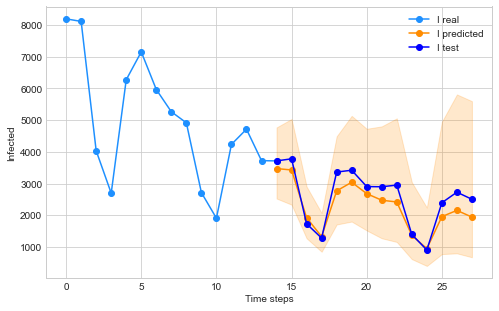

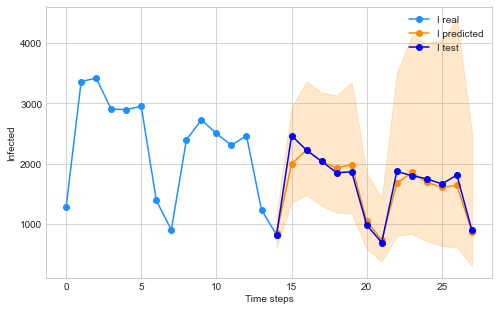

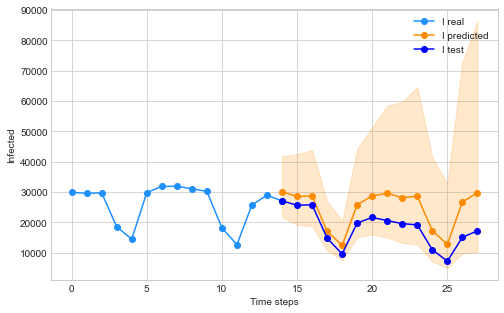

In [149]:
# forecasting
sarima = SARIMA(log_df, steps_ahead=14)
forecasts, forecasts_ci, baseline = sarima.predict_windows(verbose=False)
sarima.plot_windows()

Several conclusions can be drawn from the graphs:

- The difference between the predictions and the observed values seem not to be excessively large, but the associated uncertainty is too large, as can be seen from the prediction intervals. Unsurprisingly, it can be seen how these (i.e., the uncertainty) increase with increasing time steps into the future. While it was expected that the intervals would widen the longer the horizon, they are too large, suggesting that the predictions are not very accurate. 
- The seasonal patterns appear to be well captured by the model and therefore, the prediction intervals are smaller at these points (this pattern is constant over time).

## Forecasts exploration

The predictions generated are now explored to visually study the results. It is recalled that the subset of train data has been used to fit the model (estimate its parameters) and that the test set will be used to evaluate the model and compare it with others.

In [150]:
dates = log_test.index[:-sarima.steps_ahead+1]

y_fit = pd.DataFrame(forecasts, columns=[f'y_step_{i}' for i in range(1,sarima.steps_ahead+1)], index=dates)
lower_ci = pd.DataFrame(forecasts_ci[:,:,0], columns=[f'ci_lower_step_{i}' for i in range(1, sarima.steps_ahead+1)], index=dates)
upper_ci = pd.DataFrame(forecasts_ci[:,:,1], columns=[f'ci_upper_step_{i}' for i in range(1, sarima.steps_ahead+1)], index=dates)

A sample of the first five sets of predictions (from test data) are shown in the following table:

In [151]:
y_fit.head(5)

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11,y_step_12,y_step_13,y_step_14
Date,,,,,,,,,,,,,,
2021-05-23,2094.963547,4716.693355,5423.776719,5194.025024,5013.834456,5091.604594,2619.373050,2007.024718,4429.410754,5054.375661,4889.258621,4680.755461,4739.687615,2475.300359
2021-05-24,4562.783130,5312.435393,5073.645529,4886.534672,4952.580073,2542.304339,1908.990855,4232.736376,4844.586287,4675.605284,4467.545557,4516.380867,2354.365031,1781.257658
2021-05-25,5306.972589,5071.979917,4883.681964,4946.068266,2537.704446,1903.393984,4221.765210,4837.120497,4669.348874,4459.239229,4504.193572,2346.756503,1773.458325,3894.281544
2021-05-26,5157.210307,4933.718980,5006.042461,2572.774233,1933.549171,4286.727787,4961.747202,4777.091235,4556.056039,4610.087813,2405.735789,1821.458698,3995.306017,4593.791724
2021-05-27,5007.293332,5051.174901,2597.874046,1953.176232,4338.970245,5027.448742,4884.477270,4646.951517,4693.521172,2450.306844,1855.494573,4079.207417,4694.706630,4553.503483


The actual series (begining at time 1 instead of time 0) is plotted against the set of predictions below.

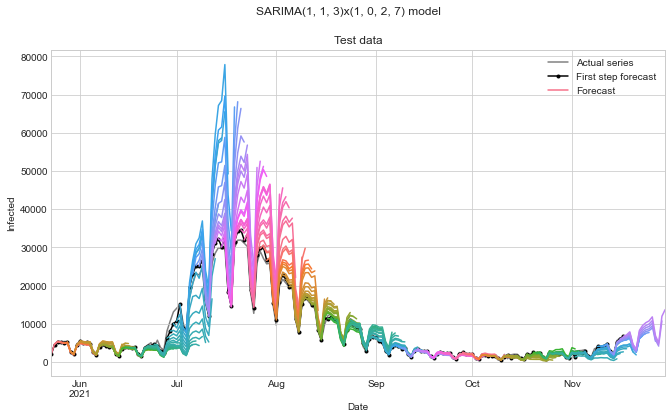

In [152]:
palette = dict(palette='husl', n_colors=64)
fig, ax1 = plt.subplots(1, 1, figsize=(11, 6))
ax1 = test[:-sarima.steps_ahead+1].plot(color='grey', zorder=0, ax=ax1)
y_fit['y_step_1'].plot(ax=ax1, color='k', style='.-', legend='First Forecast')
plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Actual series', 'First step forecast', 'Forecast'])

# set title
ax1.set_title('Test data')
fig.suptitle(f'SARIMA{sarima.order}x{sarima.seasonal_order} model')

# label axes
ax1.set_xlabel('Date')
ax1.set_ylabel('Infected')

plt.show()

For each step, a set of 14 forecasts are obtained from succesive SARIMA models as shown in the figure.

- It can be seen how the predictions follow the trend until they increase drastically when the trend increases and cases are overestimated. The prediction error in these cases is quite large.
- The seasonal pattern is collected correctly.

As the graph may be too dense to properly compare the forecasts, the one-, seven- and 14-day forecasts are now studied with their corresponding prediction intervals.

In [85]:
def compare_forecasts_at_step(step=1, test_series=None):
    """ Compare the forecasts at a given step """

    forecasts_step = y_fit[f'y_step_{step}'].values
    base = baseline
    fig = plt.figure(figsize=(20, 6))

    plt.plot(test_series[step-1:len(y_fit)+step-1].values, marker='.', label='Actual series')
    plt.plot(forecasts_step, marker='.', label=f'Forecast step {step}')
    plt.plot(base, '-.', label='Baseline')

    try: 
        lower_ci_step = lower_ci[f'ci_lower_step_{step}'].values
        upper_ci_step = upper_ci[f'ci_upper_step_{step}'].values
        plt.fill_between(range(len(forecasts_step)), lower_ci_step, upper_ci_step, color='lightgrey', alpha=0.5)
    except:
        pass 

    plt.title(f'Comparison of forecasts at step {step}')
    plt.legend()
    plt.show()

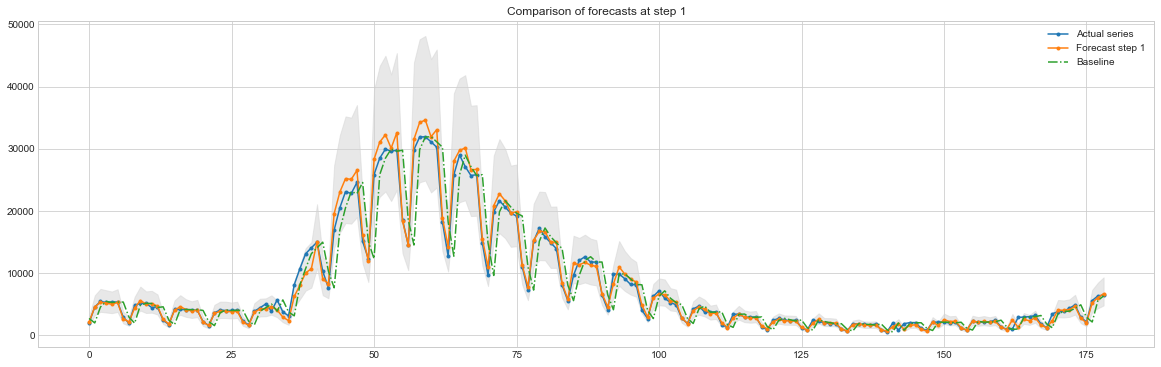

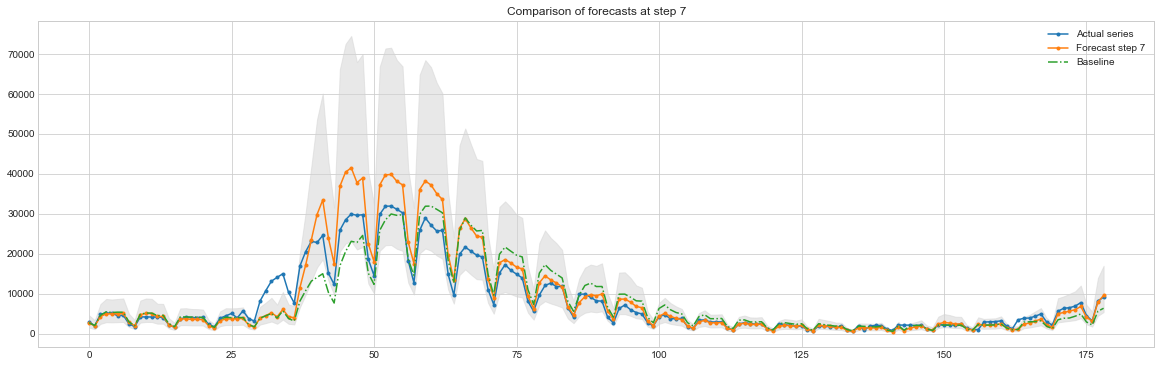

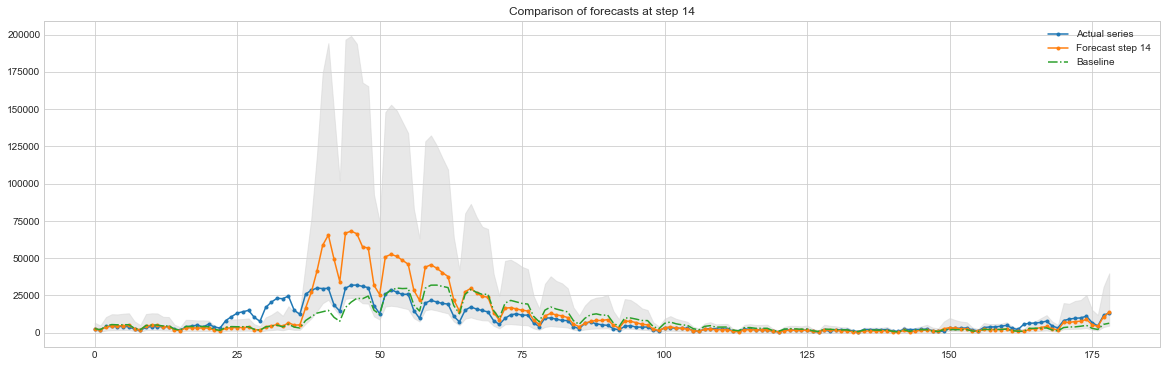

In [154]:
for step in [1, 7, 14]:
    compare_forecasts_at_step(step, test_series=test)

**Interpretation of the plots**

- The one-day ahead predictions generated by the SARIMA are accurate and clearly beat the baseline. However, the uncertainty associated with values that correspond to an increase in cases is worryingly large.
- The seven-days ahead predictions begin to differ more from the original series, and uncertainty increases even more (as expected). It seems that in general, overestimation occurs: the model expects more cases than are actually recorded.In addition, it can be seen how there are points that fall outside the prediction intervals.
- The fourteen-days ahead predictions are even more inaccurate: uncertainty increases excessively. If you plot the series without intervals (below) you can see how it does not predict the increase in cases until it has information on the rise, which then predicts more cases than occur.

## Evaluation

#TODO: describir métricas y evaluacióne

In [155]:
sarima_evaluation = sarima.evaluate()

sarima_evaluation = pd.DataFrame(sarima_evaluation)
sarima_evaluation

,step_1,baseline_step_1,step_2,baseline_step_2,step_3,baseline_step_3,step_4,baseline_step_4,step_5,baseline_step_5,...,step_10,baseline_step_10,step_11,baseline_step_11,step_12,baseline_step_12,step_13,baseline_step_13,step_14,baseline_step_14
RMSLE,0.161447,0.447255,0.175898,0.603730,0.197933,0.624048,0.223683,0.638688,0.250286,0.647979,...,0.440838,0.768728,0.483346,0.795944,0.527697,0.818649,0.571461,0.747901,0.610159,0.659628
MAE,608.949031,1801.625698,896.392599,2941.134078,1084.952637,3239.737430,1310.081293,3347.033520,1529.100789,3380.994413,...,3534.013236,4416.893855,4046.879714,4540.636872,4533.548529,4690.100559,4989.267934,4384.653631,5432.756200,4275.949721
RMSE,976.088408,3275.656702,1505.023328,4835.300651,1875.073438,5179.186055,2281.504234,5318.508271,2691.964084,5272.669031,...,6685.714199,6671.222863,7663.311515,6939.572643,8527.240731,7066.180144,9299.544317,6601.456416,10040.634281,6251.802758
MAPE,0.097967,0.309825,0.119630,0.523379,0.135043,0.549183,0.153558,0.577124,0.170577,0.582585,...,0.314677,0.701022,0.350060,0.732579,0.387839,0.761902,0.424862,0.667119,0.453261,0.536296


In [156]:
# # save the evaluation as csv in analysis folder of data
# data_results_relative_path = '../data/model-evaluation-results'
# file_name_sarima_evaluation = 'SARIMA_evaluation_h14.csv'
# path_to_save_sarima_evaluation = os.path.join(data_results_relative_path, file_name_sarima_evaluation)
# sarima_evaluation.to_csv(path_to_save_sarima_evaluation)

It should be noted that the lower the error, the better the forecast. In this analysis the point of interest is the 14-day forecast. 

Now, these results are analyzed graphically. This facilitates and speeds up interpretation of the errors.


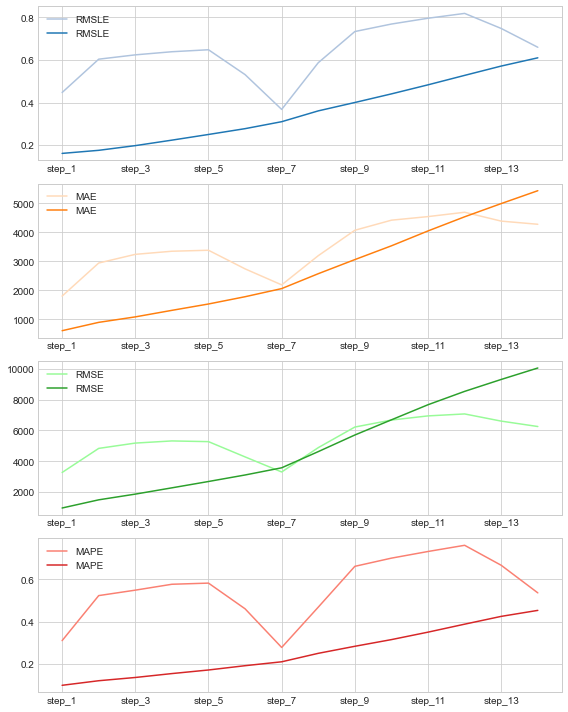

In [157]:
plot_evaluation_evolution_through_steps(sarima_evaluation)

**Interpretation of the plot**

- The most striking thing about the graphs is the value of each metric for step 7. This is due to the seasonal pattern: as observed in the images, the predictions are more accurate in the seasonal part, which causes the error to be lower.
- All metrics increase as the horizon increases. This increase is faster from step 7 onwards. 
- According to the MAE and RMSE metrics, the baseline performs better than SARIMA when the horizon is greater than 5; the RMSLE and MAPE indicate that SARIMA is better than baseline except for step 14 (which in this analysis is considered the most important), but again this is effect of the seasonal pattern.

## Forecasts residuals diagnostic

If the model has succeeded in capturing all the information and structure of the available data, then the residuals should be random. That is, residuals are the part left that cannot be predicted. The exploration of these residuals provides a better understanding of the model and its scope. If the study suggests that the residuals are not random, i.e., that they follow some pattern or structure, then the model can be improved.

Residuals are defined as the subtraction of the observed values minus the predicted values. In practice, standarized residuals are often used to detect unexpected values or outliers. They are defined as the residual divided by an estimate of the standard deviation of the residuals, so they measure the degree of difference between observed and expected values.

The residual errors for a time step ahead (t+14) using the test subset of data are obtained below:

In [158]:
# residuals = observed - forecasted
residuals = sarima.test[13:] - sarima.all_forecasts[:, -1]

The graphic exploration of (standarized) residuals can be summarized in terms of the following plots:

- Residuals line plot
- Histogram and density plot of the residuals
- Normal Q-Q residual plot of residuals
- Correlogram or autocorrelation plot of residuals

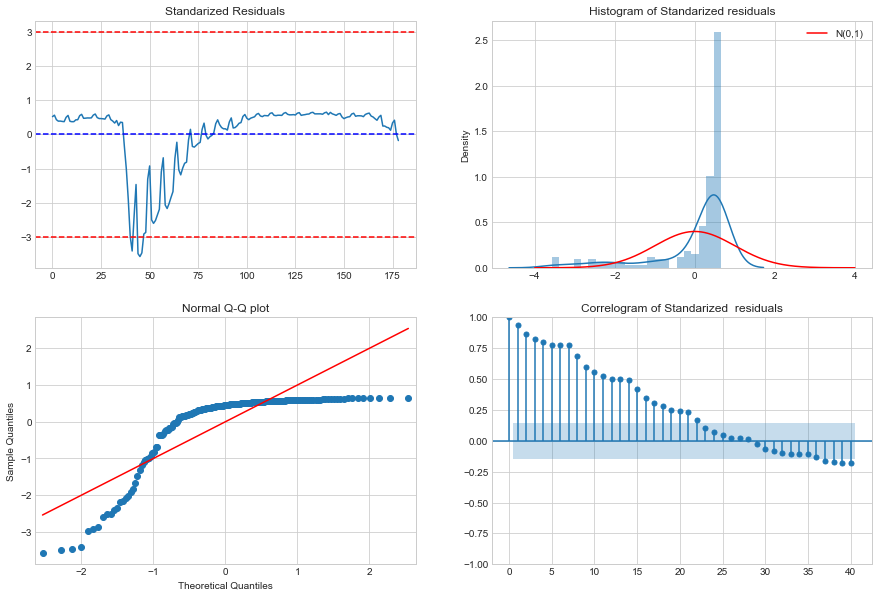

In [159]:
diagnostic_checking_residuals(residuals, True)

Some statistics are now calculated to provide information on how the values are distributed around zero. If the model was perfect, then the mean would be zero; a negative mean represents a negative bias in the forecasts; a positive mean represents a positive bias.

In [160]:
# characterize the residuals
residuals_stats(standarize_residuals(residuals))

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
0,179.0,3.969512e-17,1.002805,-3.575214,0.023824,0.458116,0.560705,0.650865,3.362638,-2.083573


The study of the residuals corresponding to the 14-day forecasts shows that the conditions and properties of the series have changed: when exploring the best SARIMA obtained, the residuals (on the train part) had good properties, which is not the case now.

- The line plot of residuals is far from that of white noise, so the series contains non-random structures that are not captured by the model. Seasonal patterns that have not been picked up by the fitted model appear, in addition to some AR or MA terms as shown in ACF plot (high correlation). Values exceeding $\pm 2$ could be considered outliers, several of which are discussed below. If the model was perfect, the resulting line plot should be iid noise, showing the residuals distributed around zero (zero mean) with no pattern (trend, seasonal components, etc.), which does not happen. 
- The standardized residuals do not follow a standard normal distribution: although they are centered around zero and their standard deviation is close to 1, they exhibit negative skewness and high positive kurtosis. Most residuals seem to be near to zero, although there are some extremely large negative errors (large tails).
- Q-Q plot confirms the previous point and highlights the outliers; confirms the presence of heavy tails (both ends of the Q-Q plot deviate from the diagonal) in comparison with a normal distribution. In this case, there are too many values that cause the distribution to deviate from a normal distribution. The outliers are large.
- Finally, the autocorrelation plot shows the relation between a observation with prior observations in time. Ideally the residuals should not be correlated. This correlogram suggests that there is autocorrelation between observations that the model does not capture. No peaks appear in it, so the seasonal part could be well represented by the model.


The points that the residual study has identified as outliers are now compared to find a possible explanation for the model's inability to capture that information. Since residuals were defined as Observed-Predicted values, a hihgly negative (standarized) residual implies that the predicted value is much higher than the observed value; conversely, a hihgly positive (standarized) residual implies that the predicted value is much lower than the observed value.

The following graph identifies the outliers and classifies them into negative and positive outliers to highlight overestimation (the model expects more infected cases than the actual observed) or underestimation (the model expects less cases than observed), respectively.

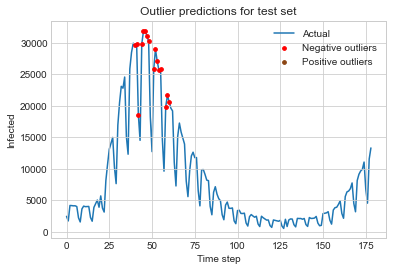

In [162]:
# predicted outliers in the test set
standarized_residuals_test = standarize_residuals(residuals)
outliers_low, = np.where(standarized_residuals_test < -2)
outliers_high, = np.where(standarized_residuals_test > 2)

test = test.values
plt.plot(test[(sarima.steps_ahead-1):], label='Actual', zorder=0)
plt.scatter(outliers_low, test[sarima.steps_ahead-1:][outliers_low], color='r', s=14, label='Negative outliers')
plt.scatter(outliers_high, test[sarima.steps_ahead-1:][outliers_high], color='saddlebrown', s=14, label='Positive outliers')

plt.legend()
plt.title('Outlier predictions for test set')
plt.xlabel('Time step')
plt.ylabel('Infected')
plt.show()

The graph can be interpreted in the following way:
- The model is unable to accurately predict the points marked as outliers in the graph.
- The red dots mean that the corresponding trained SARIMA highly overestimates the future value.
- Outliers are accumulated between points 25 and 50. This means that the model has not accurately captured the rise in cases for a 14-day horizon in the future.

# ARIMA on smoothed data

The smoothed COVID-19 infected series is now being studied. The above process is repeated to find the appropriate configuration for the model. 

## Smoothed Data

Read saved static data (csv file) of smoothed COVID-19 cases in Spain and plot it. The preprocessing of the series includes a simple moving average filter for smoothing to eliminate the weekend missing data effect.

In [4]:
# read processed data
path = 'cumulative-incidence-14-days.csv'
df_ma = load_last_final_data(file_name=path)
# show first observations
df_ma.head()

c:\Users\Bisite\Desktop\COVID-Dynamics-Model-Comparison\data\final-data\cumulative-incidence-14-days.csv


,Infected
Date,
2020-02-21,0.010685
2020-02-22,0.012821
2020-02-23,0.014958
2020-02-24,0.019232
2020-02-25,0.021369


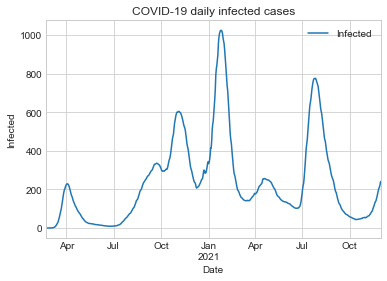

In [7]:
df_ma.plot()
plt.title('COVID-19 daily infected cases')
plt.ylabel('Infected')
plt.xlabel('Date')
plt.show()

**Interpretation of the line plot**

From the above graph, it can be concluded that:
1. The data show positive and strong autocorrelation.
2. Apparently, there is no significant trend nor seasonal patterns.

For the analysis to make sense, the data are divided into two subsets: train and test data. The necessary properties will be extracted from the train set and the model will be fitted with them. Test data will be used to make forecasts and evaluate the adjusted model. 

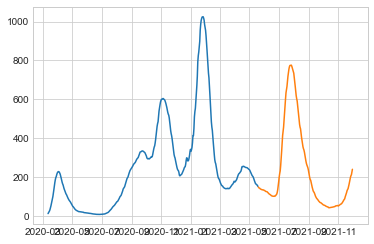

In [24]:
train_ma, test_ma = train_test_split(df_ma, test_size=0.3)
train_ma = train_ma[20:]
plt.plot(train_ma)
plt.plot(test_ma)

**Identification of parameters**

Autocorrelation and partial autocorrelation plots are explored now. 

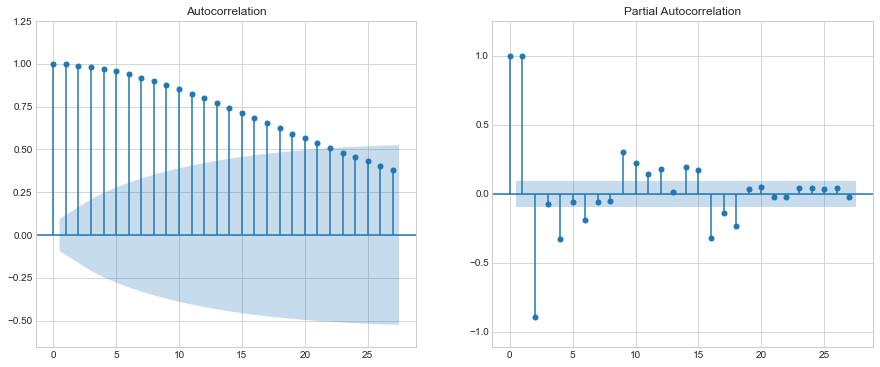

In [25]:
plot_acf_pacf(train_ma, seasonal=False, auto_ylims=True, method='ols')

**Interpretation of the autocorrelation plot**

The autocorrelation plot above shows that:
1. The sample autocorrelations are very strong and positive.
2. The sample autocorrelations decay slowly with lags, indicating that at least one difference will be required. 
3. There are no significant peaks, so the series does not contain seasonal patterns.

From the above, it follows that a certain degree of differentiation $d$ is needed to achieve stationarity. 

## Stationarity

Stationarity is checked using ADF and KPSS tests. Since there is no seasonal patterns, checking OCSB and CH tests is not necessary.

In [50]:
# test stationarity on the original series
print('Stationarity tests on the original series:')
adf_test(train_ma,  print_only_result=False)
kpss_test(train_ma, print_only_result=False)

Stationarity tests on the original series:

ADF Test Results
-----------------
ADF Statistic: -2.5701966323975074
p-value: 0.09931478213828282
num lags: 17
Critical Values:
	1% : -3.4461675720270404
	5% : -2.8685128587855955
	10% : -2.5704843086630915
Result: The timeseries is not stationary

KPSS Test Results
-----------------
KPSS Statistic: 1.102717859337201
p-value: 0.01
num lags: 12
Critical Values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Result: The timeseries is not stationary


As expected, both tests conclude the series is not stationary. First differenced series has to be studied now.

### Differenced series ($d=1$)

The plot below shows the differenced series for $d=1$. 

         Infected
count  433.000000
mean     0.322348
std     13.286423
min    -48.116805
25%     -3.735319
50%     -0.017095
75%      4.301600
max     75.569690


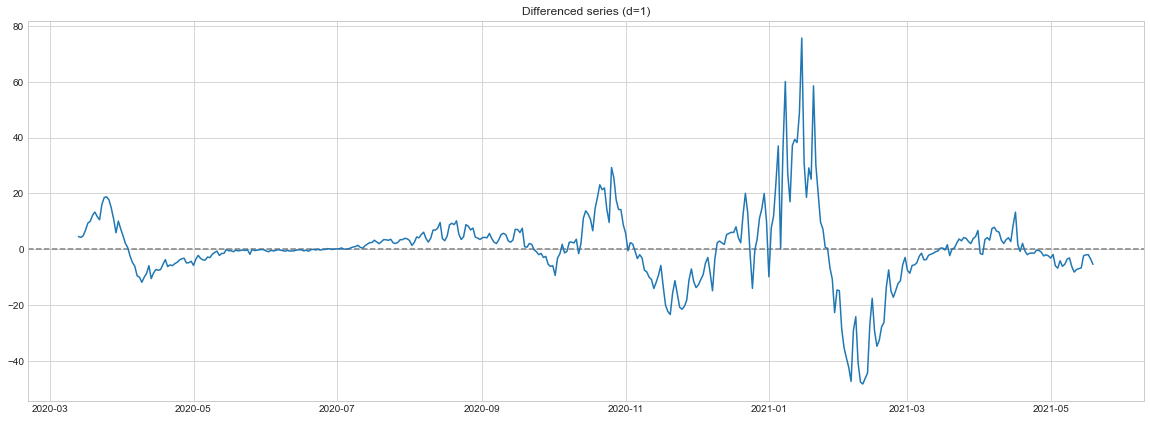

In [54]:
# take one difference (d=1)
df_ma_d1 = train_ma.diff().dropna()
# plot the differenced series
fig = plt.figure(figsize=(20, 7))
# plot horizontal line 
plt.axhline(y=0, color='grey', linestyle='--')
plt.title('Differenced series (d=1)')
plt.plot(df_ma_d1)
print(df_ma_d1.describe())

**Interpretation of the differenced series**

Although the series now appears to have zero mean, the variance varies. Therefore, a logarithmic transformation could be useful to stabilize the variance.

### Log transform

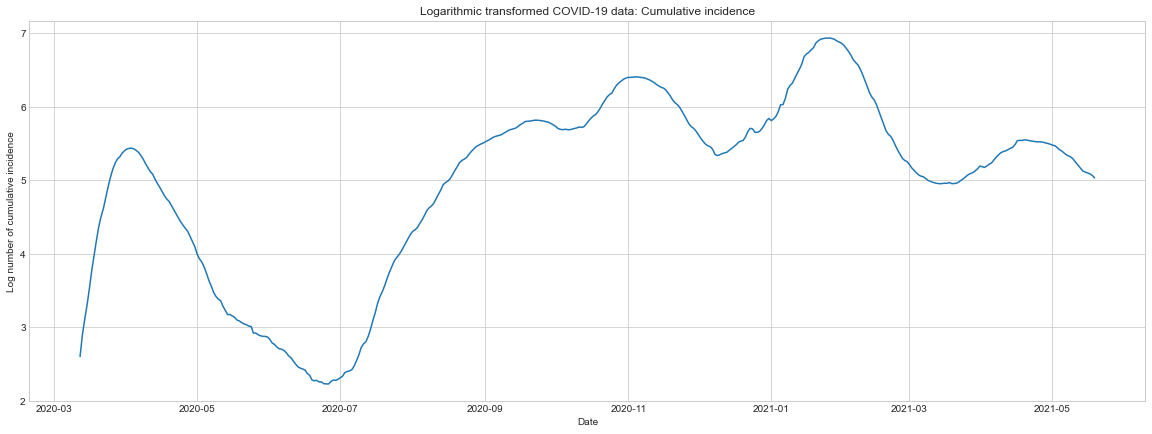

In [55]:
# apply a log transformation to the original data (having ensured that there is no zero value)
log_series_ma = np.log(train_ma)

# plot log-transformed data to confirm that the seasonal effect is now additive
fig = plt.figure(figsize=(20, 7))
plt.plot(log_series_ma)
plt.xlabel('Date')
plt.ylabel('Log number of cumulative incidence')
plt.title('Logarithmic transformed COVID-19 data: Cumulative incidence')
plt.show()

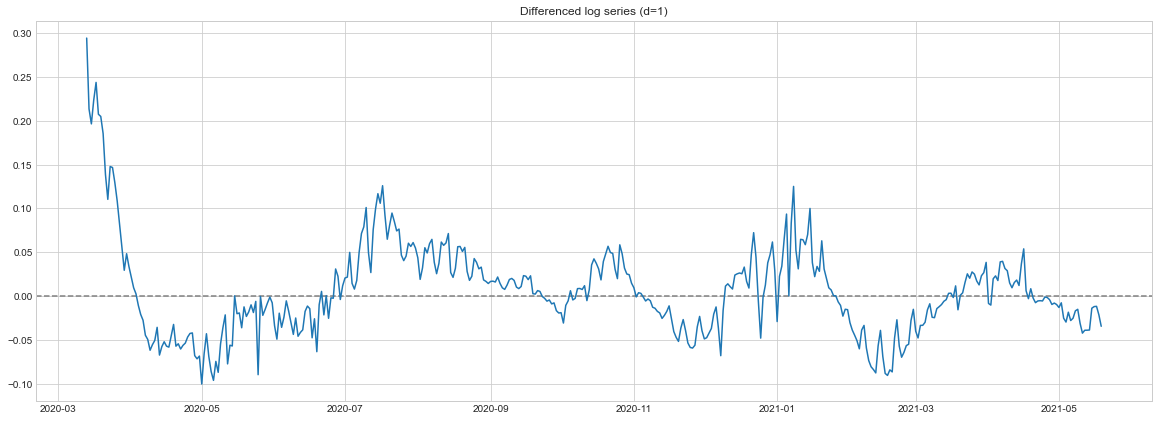

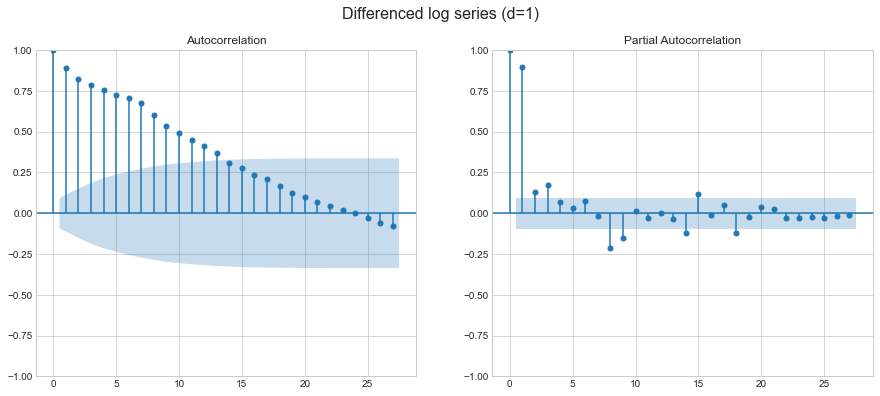

         Infected
count  433.000000
mean     0.005613
std      0.053215
min     -0.100044
25%     -0.027384
50%     -0.000779
75%      0.029100
max      0.294246


In [56]:
# difference the log series
df_ma_d1 = log_series_ma.diff().dropna()

# plot the resulting series
fig = plt.figure(figsize=(20, 7))
plt.title('Differenced log series (d=1)')
plt.axhline(y=0, color='grey', linestyle='--')
plt.plot(df_ma_d1)
plot_acf_pacf(df_ma_d1, 'Differenced log series (d=1)', seasonal=False)
print(df_ma_d1.describe())


In [57]:
# test stationarity on the original series
print('Stationarity tests on the differenced log series:')
adf_test(df_ma_d1,  print_only_result=False)
kpss_test(df_ma_d1, print_only_result=False)

Stationarity tests on the differenced log series:

ADF Test Results
-----------------
ADF Statistic: -3.6971662895535977
p-value: 0.004153189827042289
num lags: 17
Critical Values:
	1% : -3.446205926287236
	5% : -2.8685297226414734
	10% : -2.570493298011322
Result: The timeseries is stationary

KPSS Test Results
-----------------
KPSS Statistic: 0.19806625854100063
p-value: 0.1
num lags: 12
Critical Values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Result: The timeseries is stationary


So the series is stationary. If a second order differenced series is studied, one can see that it may be overdifferenced. 

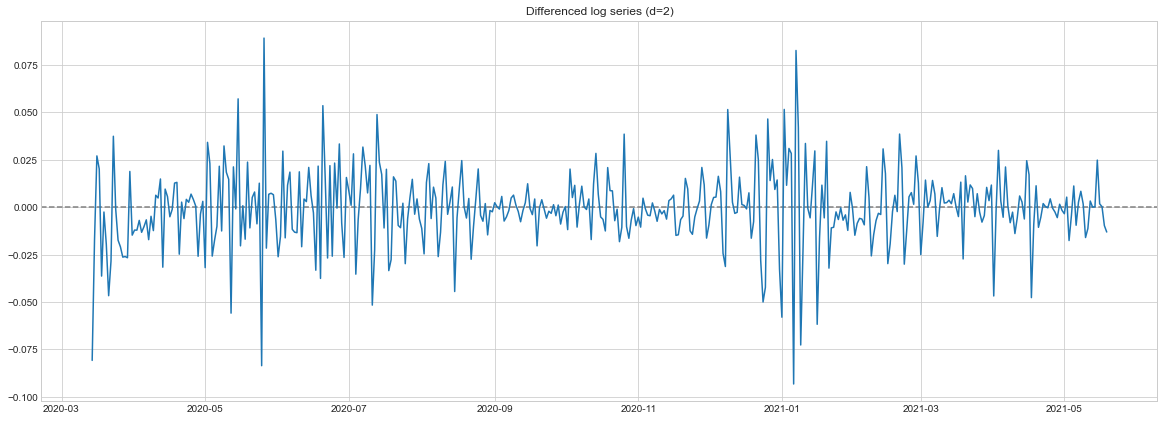

In [31]:
# difference d=2 the log series
df_ma_d2 = df_ma_d1.diff().dropna()

# plot the resulting series
fig = plt.figure(figsize=(20, 7))
plt.title('Differenced log series (d=2)')
plt.axhline(y=0, color='grey', linestyle='--')

plt.plot(df_ma_d2)

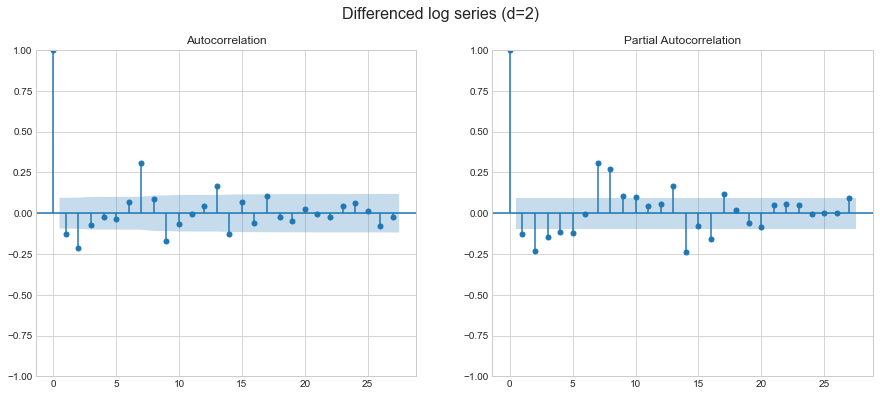

In [32]:
plot_acf_pacf(df_ma_d2, 'Differenced log series (d=2)', seasonal=False)

## Take the log series
Since the differentiated transformed series is stationary, the logarithmically transformed series is taken to work on it.



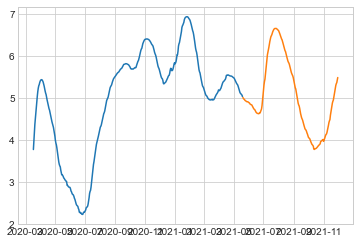

In [33]:
log_df_ma = np.log(df_ma)
log_train_ma, log_test_ma = train_test_split(log_df_ma, test_size=0.3)
log_train_ma = log_train_ma[25:]
plt.plot(log_train_ma)
plt.plot(log_test_ma)

## Estimation of ARIMA model

A difference $d=1$ was needed to make the series stationary; the series lacks stationarity. The next step is to find the order of the parameters $p,q$.

In [34]:
ma_model = pm.auto_arima(np.array(log_train_ma), 
                    seasonal=False, # not a seasonal series
                    d=1, # one difference required
                    error_action='ignore', 
                    parallelized=True)

In [36]:
model_parameters = ma_model.get_params()
order = model_parameters['order']
seasonal_order = model_parameters['seasonal_order']

print('Best estimated order: \n\t (p, d, q) =', order)
print('Best estimated seasonal order: \n\t (P, D, Q, m) =', seasonal_order)

Best estimated order: 
	 (p, d, q) = (2, 1, 5)
Best estimated seasonal order: 
	 (P, D, Q, m) = (0, 0, 0, 0)


### Model Diagnostic Checking

Results of the fitted model are now checked.

In [37]:
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  429
Model:               SARIMAX(2, 1, 5)   Log Likelihood                1126.535
Date:                Thu, 18 Aug 2022   AIC                          -2237.070
Time:                        18:03:30   BIC                          -2204.597
Sample:                             0   HQIC                         -2224.244
                                - 429                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4747      0.099     14.953      0.000       1.281       1.668
ar.L2         -0.4887      0.098     -4.975      0.000      -0.681      -0.296
ma.L1         -0.8559      0.101     -8.485      0.0

#### Interpretation of model results
 
Residuals diagnostic:

- Ljung-Box (L1) (Q) is the Ljung-Box test at lag 1. The value of the statistic is 0.03 and the $p$ -value is 0.87>0.05. This implies that the $H_0$ is not rejected and therefore the residuals are white noise.
- Heteroskedasticity (H). The test statistic is 27.57 and the $p$ -value is 0.13>0.05. This implies that the $H_0$ is not rejected and therefore the residuals are not heteroskedastic.
- Jarque-Bera (JB) statistic is 10082.18 and the $p$ -value is 0<0.05. This implies that the $H_0$ is rejected and therefore the residuals are not normally distributed. In addition, the residuals have a slight positive skew and a pretty large kurtosis.

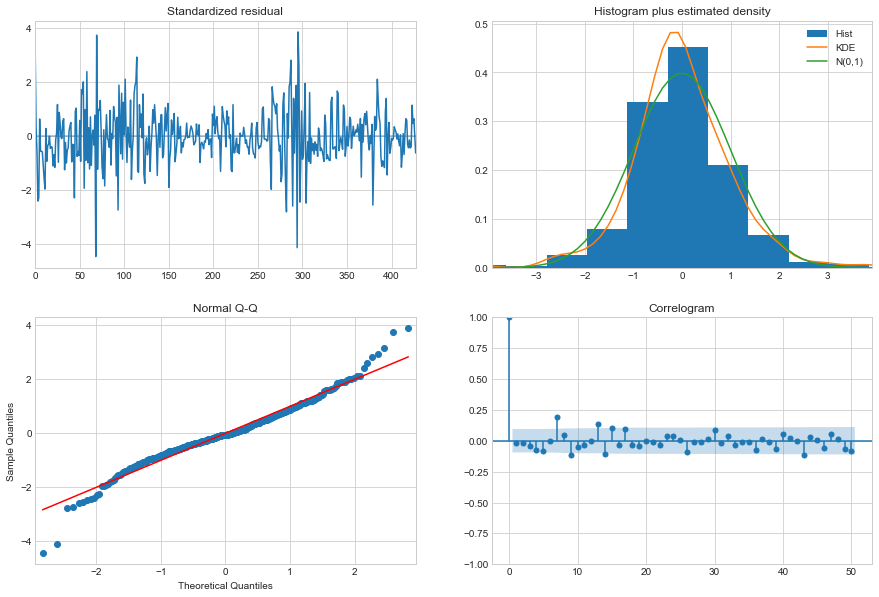

In [58]:
# graphic diagnostic
ma_model.plot_diagnostics(figsize=(15,10), lags=50)
plt.show()

**Interpretation of the diagnostics graphs**

- The standarized residuals seem to have **zero mean** and highly variable variance.  
<!-- It can also be deduced that the **variance is not constant** over time. -->
- The histogram and density plot show how the residuals **differ from a normal distribution**. It can be seen the slight **negative skew and a high positive excess of kurtosis**.
- The Q-Q plot can help to asses if the residuals came from a theoretical normal distribution. If both sample-theoretical sets of quantiles came from the same distribution, the points should form a diagonal straight line. In this case, the Q-Q plot shows a distribution with **heavy tails** (as confirmed by the kurtosis above) vs. the normal distribution: most points are clustered on a line in the center of the plot, and some points curve (due to slight negative) and move away from the line in the extremities (due to slight negative skew and kurtosis). This means that the residuals have more extreme values or **outliers** relative to a normal distribution. <!-- https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html -->
- The correlogram help in identifying the residuals randomness. The standard errors for confidence intervals are determined under the hypothesis that the residuals are white noise. Since they are close to zero and almost none exceed the confidence intervals, the **residuals are white noise**.

#### Conclusion

The best model found is ARIMA(3, 1, 3)x(0, 0, 0, 0), this is:
- AR(3): the current value of the series $Y_t$ depends on the previous values $Y_{t-1}, Y_{t-2},Y_{t-3}$ of the series adjusted by some parameters (plus a constant term and a white noise value $\varepsilon_t$). 
- d=1: the series has no constant properties, so two differencings were necessary.
- MA(3): the current value of the series $Y_t$ depends on the adjusted previous white noise terms $\varepsilon_{t-1}, \varepsilon_{t-2}, \varepsilon_{t-3}$ (plus a constant term and the current white noise term $\varepsilon_{t}$).

The residuals diagnostic concludes that the model captures all the non random patterns in data. 

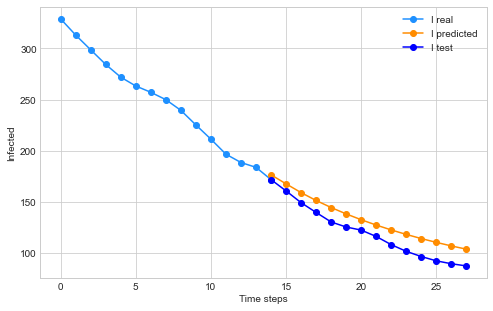

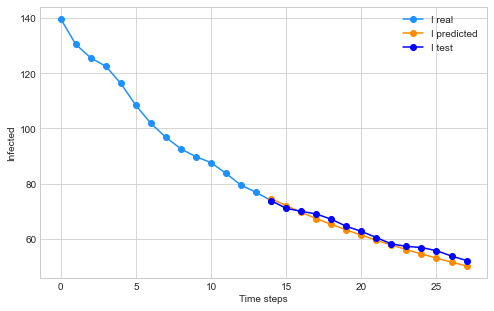

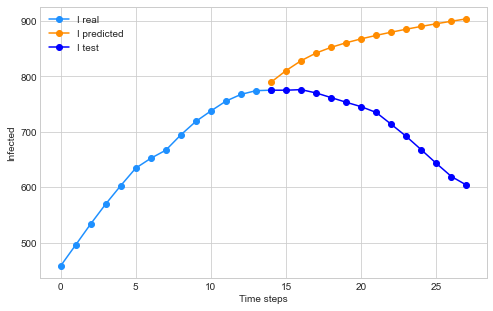

In [40]:
# forecasting
arima = SARIMA(log_df_ma, order=order, seasonal_order=(0, 0, 0, 0))
forecasts, forecasts_ci, baseline = arima.predict_windows(verbose=False)
arima.plot_windows()

Now the predictions made with this model for the smoothed series will be explored.

In [82]:
test_dates = test_ma.index[:-arima.steps_ahead+1]
test_y_fit = pd.DataFrame(forecasts, columns=[f'y_step_{i}' for i in range(1,arima.steps_ahead+1)], index=test_dates)
test_lower_ci = pd.DataFrame(forecasts_ci[:,:,0], columns=[f'ci_lower_step_{i}' for i in range(1, arima.steps_ahead+1)], index=test_dates)
test_upper_ci = pd.DataFrame(forecasts_ci[:,:,1], columns=[f'ci_upper_step_{i}' for i in range(1, arima.steps_ahead+1)], index=test_dates)

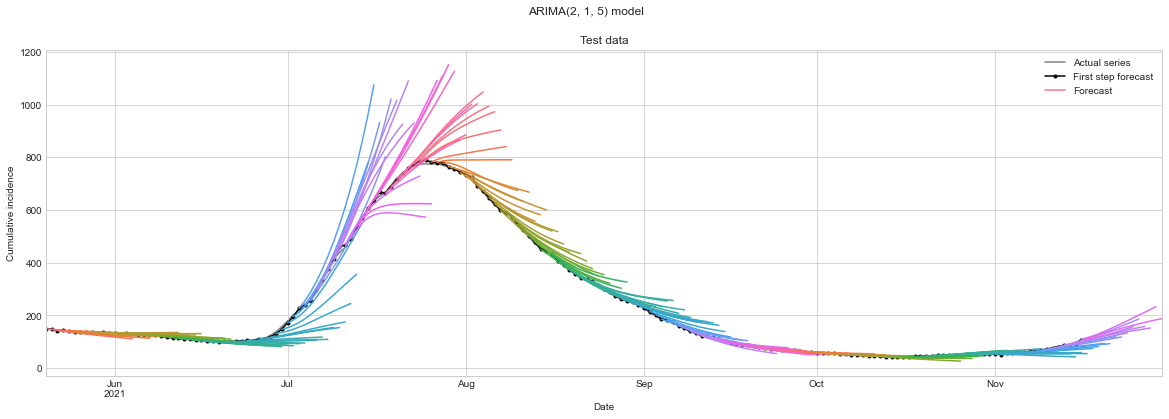

In [83]:
palette = dict(palette='husl', n_colors=64)
# fig, ax1 = plt.subplots(1, 1, figsize=(11, 6))
fig, ax2 = plt.subplots(1, 1, figsize=(20, 6))

# # train data
# ax1 = train_ma.plot(color='grey', zorder=0, ax=ax1)
# train_y_fit['y_step_1'].plot(ax=ax1, color='k', style='.-', legend='First Forecast')
# plot_multistep(train_y_fit, ax=ax1, palette_kwargs=palette)
# _ = ax1.legend(['Actual series', 'First step forecast', 'Forecast'])

# test data
ax2 = test_ma[:-arima.steps_ahead+1].plot(color='grey', zorder=0, ax=ax2)
test_y_fit['y_step_1'].plot(ax=ax2, color='k', style='.-', legend='First Forecast')
plot_multistep(test_y_fit, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Actual series', 'First step forecast', 'Forecast'])

# set title
# ax1.set_title('Train data')
ax2.set_title('Test data')
fig.suptitle(f'ARIMA{arima.order} model')

# label axes
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Infected')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative incidence')

# set same y scale for both axes
# ax2.set_ylim(ax1.get_ylim())

plt.show()

For each step, a set of 14 forecasts are obtained from ARIMA models as shown in the figure.
- The model is not capable to predict the rise of cases 14 days in the future until it incorporates information about this rise. When this information has already been observed, the model expects more cases than actually occur.

As the graph may be too dense to properly compare the forecasts, the 1-, 7- and 14-day forecasts are now studied.



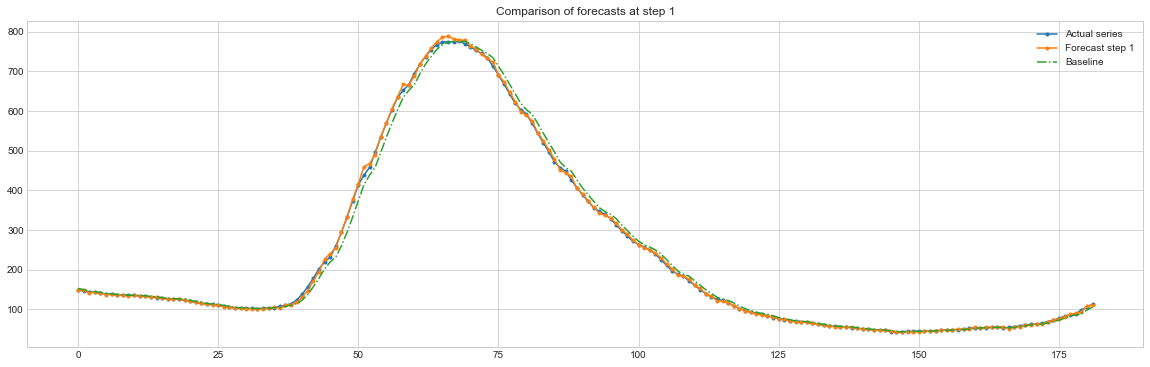

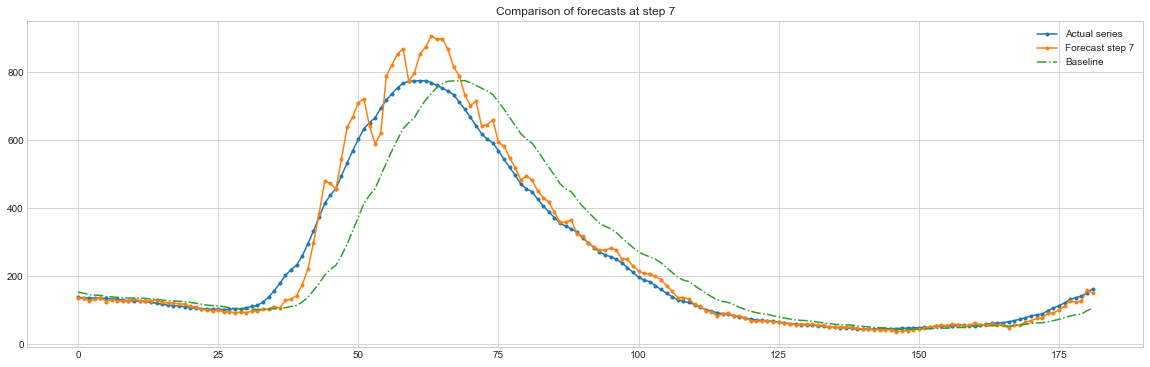

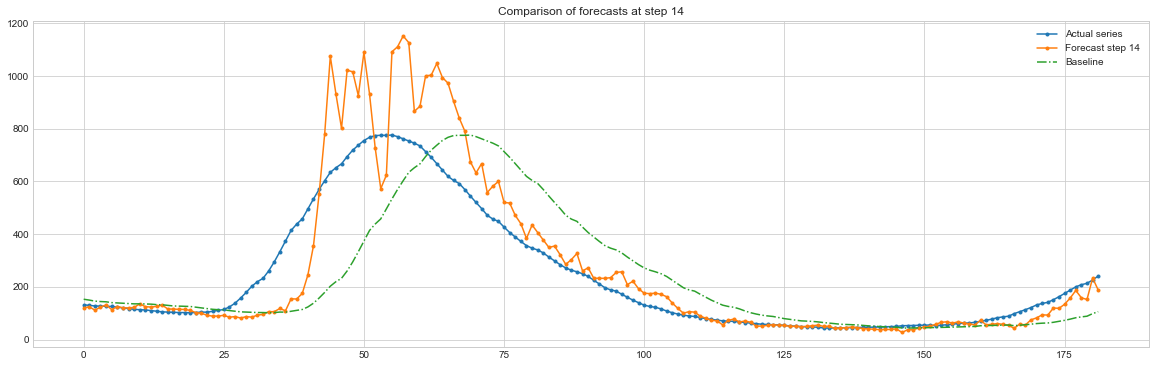

In [86]:
y_fit = test_y_fit.copy()

for step in [1, 7, 14]:
    compare_forecasts_at_step(step, test_series=test_ma)

- The predictions generated for the next step seem quite accurate and tend to outperform the baseline. 
- The 7-day forecasts present greater error and uncertainty, which becomes more pronounced as the number of cases rises. As mentioned above, after an initial underestimation (inability to predict the initial rise), the model overestimates the cases.
- The effect mentioned in the previous point is repeated for the 14-day forecasts, but it is intensified and increases the error and uncertainty. This is to be expected.

# Evaluation

In [87]:
base_dir = Path(os.getcwd()).parents[0]
path_to_store_results = os.path.join(base_dir, 'data', 'model-evaluation-results')
path_to_save_image = os.path.join(path_to_store_results, f'ci_ARIMA_{order}_evaluation.png')

In [88]:
evaluation_arima = arima.evaluate()
evaluation_arima = pd.DataFrame(evaluation_arima)
evaluation_arima

,step_1,baseline_step_1,step_2,baseline_step_2,step_3,baseline_step_3,step_4,baseline_step_4,step_5,baseline_step_5,...,step_10,baseline_step_10,step_11,baseline_step_11,step_12,baseline_step_12,step_13,baseline_step_13,step_14,baseline_step_14
RMSLE,0.017255,0.044669,0.035332,0.087802,0.051714,0.130314,0.068014,0.172352,0.085352,0.213960,...,0.212984,0.421955,0.244657,0.462653,0.278029,0.502632,0.312062,0.542170,0.347447,0.581403
MAE,2.404678,8.426694,5.454387,16.821745,8.249523,25.241582,11.181356,33.666162,14.354911,42.066203,...,41.693714,83.935293,48.951431,92.226763,56.813644,100.481025,65.178620,108.614551,74.037291,116.737862
RMSE,3.890640,12.970530,9.217906,25.652707,14.262720,38.115322,19.669306,50.441805,25.473933,62.644759,...,70.797404,122.341278,83.232373,133.778122,96.605798,144.963145,110.819762,155.923082,126.100083,166.673361
MAPE,0.012232,0.034796,0.025061,0.068774,0.035534,0.102528,0.045731,0.136120,0.056712,0.169835,...,0.146025,0.341402,0.167536,0.376601,0.189831,0.412037,0.212958,0.447931,0.236852,0.484307


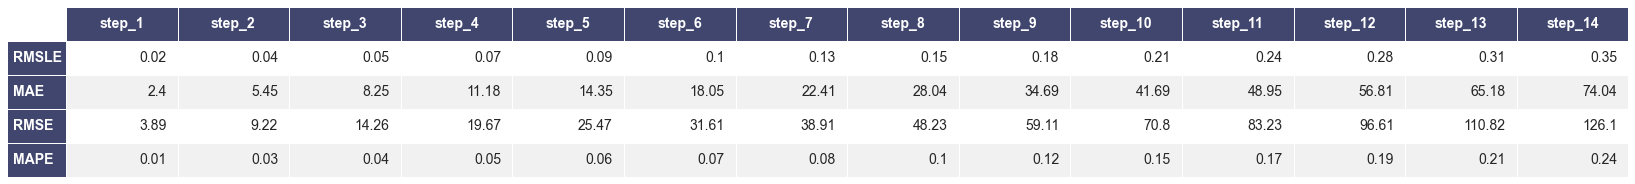

In [90]:
eval = evaluation_arima.T[::2].T.round(2)
show_eval_table_and_save(eval, path_to_save_image)

In [100]:
# save the evaluation as csv in analysis folder of data
data_results_relative_path = '../data/model-evaluation-results'
file_name_evaluation = f'ci_ARIMA_{order}_evaluation.csv'
path_to_save_evaluation = os.path.join(data_results_relative_path, file_name_evaluation)
eval.to_csv(path_to_save_evaluation)

In [94]:
# print(eval.to_latex(header=[f'h={i}' for i in range(1,15)]))

It should be noted that the lower the error, the better the forecast. In this analysis the point of interest is the 14-day forecast. 

Now, these results are analyzed graphically. This facilitates and speeds up interpretation of the errors.


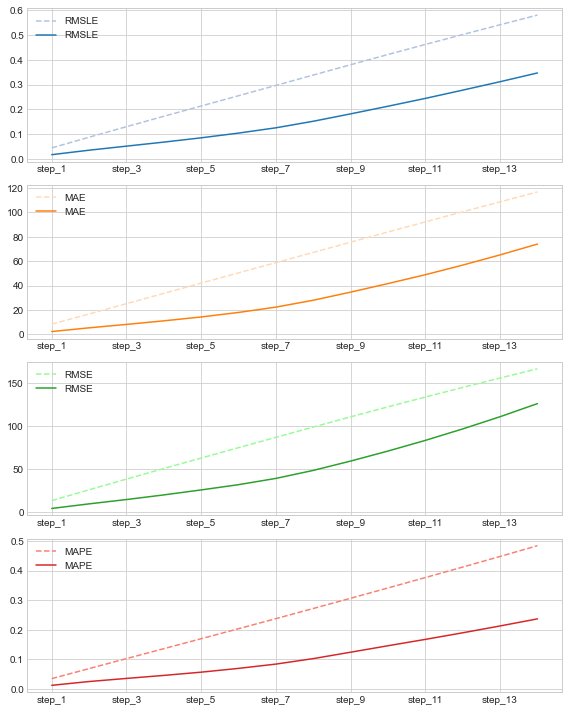

In [95]:
plot_evaluation_evolution_through_steps(evaluation_arima)

**Interpretation of the plot**

- All metrics increase as the horizon increases. 
- According to the MAE and RMSE metrics, ARIMA performs better than the baseline model in all cases.

## Forecasts residuals diagnostic

If the model has succeeded in capturing all the information and structure of the available data, then the residuals should be random. That is, residuals are the part left that cannot be predicted. The exploration of these residuals provides a better understanding of the model and its scope. If the study suggests that the residuals are not random, i.e., that they follow some pattern or structure, then the model can be improved.

Residuals are defined as the subtraction of the observed values minus the predicted values. In practice, standarized residuals are often used to detect unexpected values or outliers. They are defined as the residual divided by an estimate of the standard deviation of the residuals, so they measure the degree of difference between observed and expected values.

The residual errors for a time step ahead (t+14) using the test subset of data are obtained below:

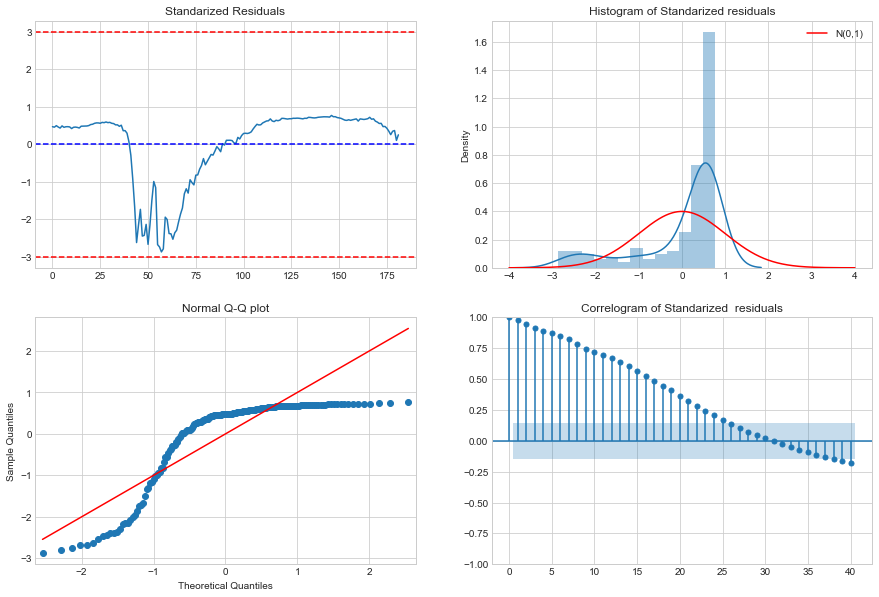

In [96]:
# residuals = observed - forecasted
residuals_ma = arima.test[13:] - arima.all_forecasts[:, -1]
diagnostic_checking_residuals(residuals_ma)


Some statistics are now calculated to provide information on how the values are distributed around zero. If the model was perfect, then the mean would be zero; a negative mean represents a negative bias in the forecasts; a positive mean represents a positive bias.

In [97]:
# characterize the residuals
residuals_stats(standarize_residuals(residuals_ma))

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
0,182.0,2.342449e-16,1.002759,-2.875557,-0.168557,0.474566,0.650773,0.76905,1.186844,-1.587607


The study of the residuals corresponding to the 14-day forecasts shows that the conditions and properties of the series have changed: when exploring the best ARIMA obtained, the residuals (on the train part) had good properties, which is not the case now.

- The line plot of residuals is far from that of white noise, so the series contains non-random structures that are not captured by the model. Seasonal patterns that have not been picked up by the fitted model appear, in addition to some AR or MA terms as shown in ACF plot (high correlation). Values exceeding $\pm 2$ could be considered outliers, several of which are discussed below. If the model was perfect, the resulting line plot should be iid noise, showing the residuals distributed around zero (zero mean) with no pattern (trend, seasonal components, etc.), which does not happen. 
- The standardized residuals do not follow a standard normal distribution: although they are centered around zero and their standard deviation is close to 1, they exhibit negative skewness and positive kurtosis. Most residuals seem to be near to zero, although there are some extremely large negative errors (large tails).
- Q-Q plot confirms the previous point and highlights the outliers; confirms the presence of heavy tails (both ends of the Q-Q plot deviate from the diagonal) in comparison with a normal distribution. In this case, there are too many values that cause the distribution to deviate from a normal distribution. The outliers are large.
- Finally, the autocorrelation plot shows the relation between a observation with prior observations in time. Ideally the residuals should not be correlated. This correlogram suggests that there is autocorrelation between observations that the model does not capture. 

The points that the residual study has identified as outliers are now compared to find a possible explanation for the model's inability to capture that information. Since residuals were defined as Observed-Predicted values, a hihgly negative (standarized) residual implies that the predicted value is much higher than the observed value; conversely, a hihgly positive (standarized) residual implies that the predicted value is much lower than the observed value.

The following graph identifies the outliers and classifies them into negative and positive outliers to highlight overestimation (the model expects more infected cases than the actual observed) or underestimation (the model expects less cases than observed), respectively.

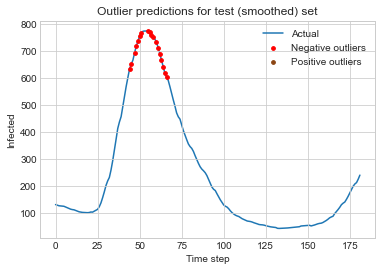

In [98]:
# predicted outliers in the test_ma set
standarized_residuals_test_ma = standarize_residuals(residuals_ma)
outliers_low, = np.where(standarized_residuals_test_ma < -2)
outliers_high, = np.where(standarized_residuals_test_ma > 2)

test_ma = test_ma.values
plt.plot(test_ma[(arima.steps_ahead-1):], label='Actual', zorder=0)
plt.scatter(outliers_low, test_ma[arima.steps_ahead-1:][outliers_low], color='r', s=14, label='Negative outliers')
plt.scatter(outliers_high, test_ma[arima.steps_ahead-1:][outliers_high], color='saddlebrown', s=14, label='Positive outliers')

plt.legend()
plt.title('Outlier predictions for test (smoothed) set')
plt.xlabel('Time step')
plt.ylabel('Infected')
plt.show()

The graph can be interpreted in the following way:
- The model is unable to accurately predict the points marked as outliers in the graph.
- The red dots mean that the corresponding trained ARIMA highly overestimates the future value (for 14 forecast ahead).
- Outliers are accumulated between points 25 and 50. This means that the model has not accurately captured the rise in cases for a 14-day horizon in the future.

# Conclusions ARIMA

This model is shown to obtain relatively accurate predictions when past conditions are appropriate. It is also interpretable and its computational cost is not high. On the other hand, the fact that the model initially satisfies the conditions and does not do so later suggests that perhaps window adjustments of the model should be studied, which is beyond the scope of this paper. Moreover, this process requires expert knowledge and is more complicated to automate. 